# Machine-Learning-API-s-with-FastAPI


##   BUSINESS UNDERSTANDING

## Project Overview
The project revolves around building a classification system using machine learning techniques to predict occurrences of blood poisoning. Additionally, it involves developing an API for seamless interaction with the model, aiding in early identification and intervention for blood poisoning cases.

## Hypothesis

H0: There is NO RELATIONSHIP between patient health indicators and the likelihood of developing sepsis.

H1: There is A RELATIONSHIP between patient health indicators and the likelihood of developing sepsis.
 
(Broad hypothesis is to be refined after Initial exploration)

## Analytical Questions

1. How many patients have valid insurance cards, and what percentage of patients does this represent?
2. What are the average plasma glucose (PRG) and blood pressure (PR) levels among patients?
3. Is there a correlation between body mass index (M11) and blood work results (PL, SK, TS, BD2)?
4.  What is the percentage of patients who develop sepsis (Sepssis) in the dataset?
5. Which features (PRG, PL, PR, SK, TS, M11, BD2, Age, Insurance) are most predictive of sepsis development?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_qqplot import pplot


from ydata_profiling import ProfileReport
import copy

from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pickle



from scipy.stats import shapiro,  norm, boxcox, mannwhitneyu
import sys
sys.path.append("../src")

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

#


##  DATA UNDERSTANDING 


## 1A. Understanding data surface properties

In [2]:
train_df = pd.read_csv("../data/raw/Paitients_Files_Train.csv")
test_df = pd.read_csv("../data/raw/Paitients_Files_Test.csv")
train_df

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive
...,...,...,...,...,...,...,...,...,...,...,...
594,ICU200604,6,123,72,45,230,33.6,0.733,34,0,Negative
595,ICU200605,0,188,82,14,185,32.0,0.682,22,1,Positive
596,ICU200606,0,67,76,0,0,45.3,0.194,46,1,Negative
597,ICU200607,1,89,24,19,25,27.8,0.559,21,0,Negative


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


In [4]:
test_df

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,ICU200609,1,109,38,18,120,23.1,0.407,26,1
1,ICU200610,1,108,88,19,0,27.1,0.400,24,1
2,ICU200611,6,96,0,0,0,23.7,0.190,28,1
3,ICU200612,1,124,74,36,0,27.8,0.100,30,1
4,ICU200613,7,150,78,29,126,35.2,0.692,54,0
...,...,...,...,...,...,...,...,...,...,...
164,ICU200773,10,101,76,48,180,32.9,0.171,63,1
165,ICU200774,2,122,70,27,0,36.8,0.340,27,1
166,ICU200775,5,121,72,23,112,26.2,0.245,30,1
167,ICU200776,1,126,60,0,0,30.1,0.349,47,1


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         169 non-null    object 
 1   PRG        169 non-null    int64  
 2   PL         169 non-null    int64  
 3   PR         169 non-null    int64  
 4   SK         169 non-null    int64  
 5   TS         169 non-null    int64  
 6   M11        169 non-null    float64
 7   BD2        169 non-null    float64
 8   Age        169 non-null    int64  
 9   Insurance  169 non-null    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 13.3+ KB


## 1B. Understanding data content and quality

In [6]:
profile = ProfileReport(train_df, dark_mode=True, title="Profile of Sepsis Data")

**Surface Property Summary**

**Dataset Source:** The John Hopkins Universtiy

**Abstract:**  The dataset contains comprehensive information about the health status of patients in the ICU, including details on Patients information and clinical measurements. 

**Features:** 
- PRG -- Plasma glucose
- PL  -- Blood Work Result-1 (mu U/ml)
- PR  -- Blood Pressure (mm Hg)
- SK  -- Blood Work Result-2 (mm)
- TS  -- Blood Work Result-3 (mu U/ml)
- M11 -- Body mass index (weight in kg)/(height in m)^2
- BD2 -- Blood Work Result-4 (mu U/ml)
- Age -- patients age (years)
- Insurance	--	If a patient holds a valid insurance card

**Target:**
- Sepsis --	Positive: if a patient in ICU will develop a sepsis , and Negative: otherwise

**Data Type:**  Multivariate

**Format Type:**  Matrix


Dataset seems to be clean, with all variables assigned their right data types. 

In [9]:
num_cols = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']

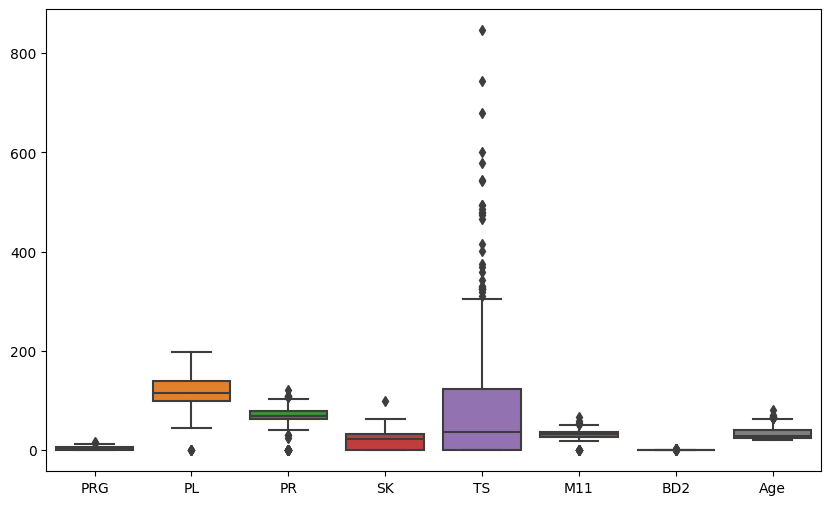

In [10]:
## check outliers 
fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.boxplot(train_df[num_cols])

In [11]:
def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    """Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    column and outlier_col the columns with a binary value (outlier or not).

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """

    # Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/util/VisualizeDataset.py

    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["outlier " + col, "no outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()


In [12]:
def mark_outliers_iqr(dataset, col):
    """Function to mark values as outliers using the IQR method.

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()

    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset[col + "_outlier"] = (dataset[col] < lower_bound) | (
        dataset[col] > upper_bound
    )

    return dataset


In [13]:
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 100

In [14]:
col = "PRG"
data = mark_outliers_iqr(dataset=train_df, col=col)
data.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis,PRG_outlier
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive,False
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative,False
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive,False
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative,False
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive,False


Using the Interquartile range, there's quite a number of outliers present.  Let's visualize the data to see where the outliers occur

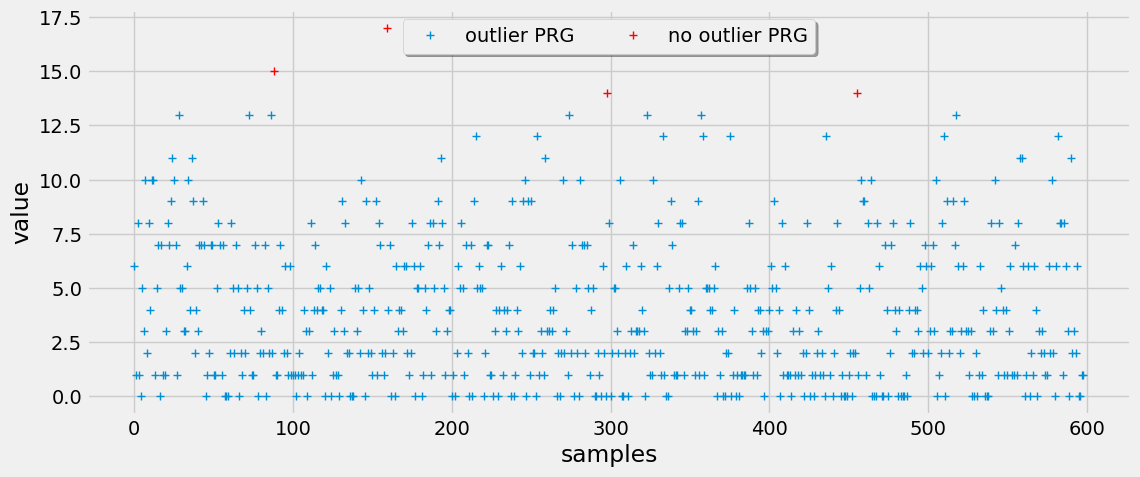

In [15]:
plot_binary_outliers(dataset=data, col=col, outlier_col=col + "_outlier", reset_index=True)

We repeat this for the rest of the columns
 

5 outliers in column PL


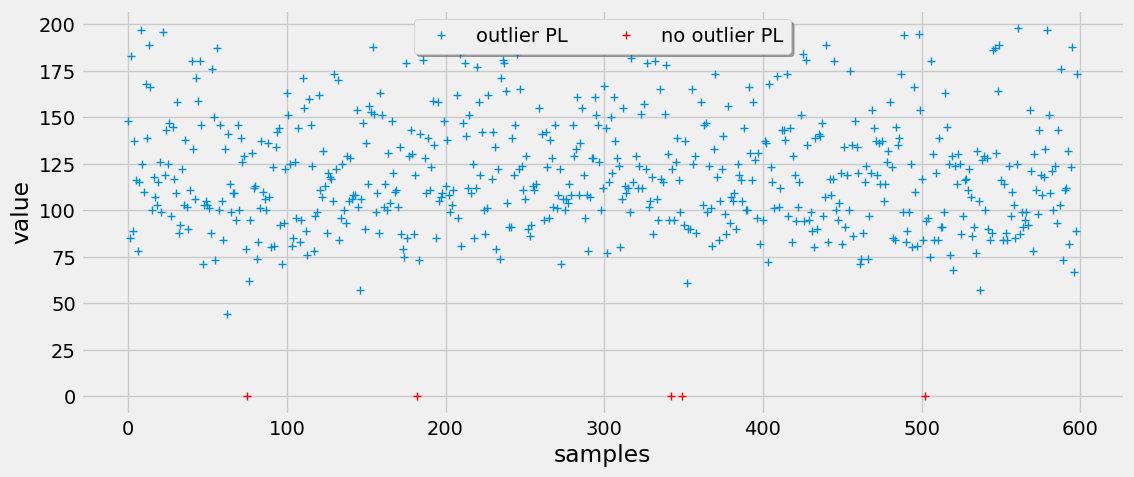

37 outliers in column PR


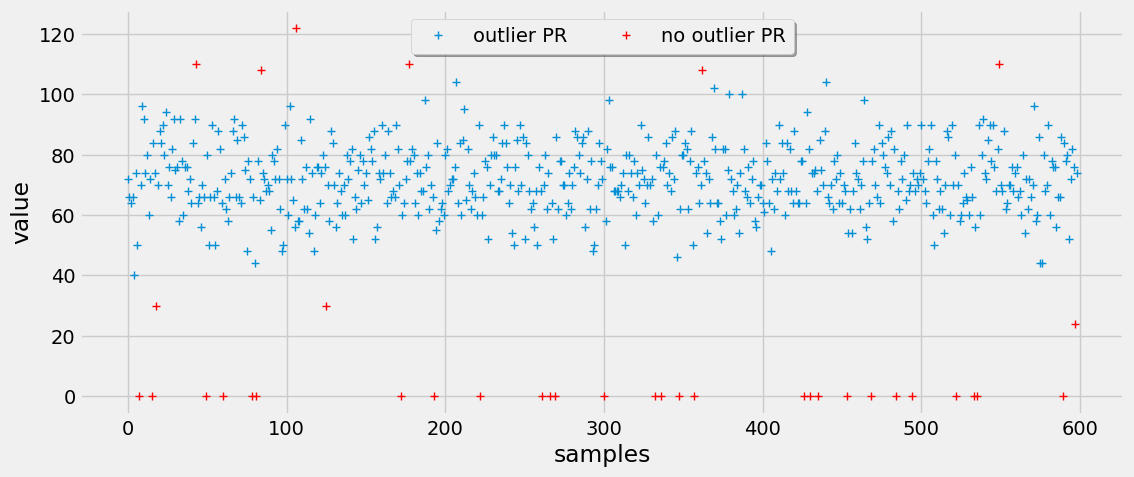

1 outliers in column SK


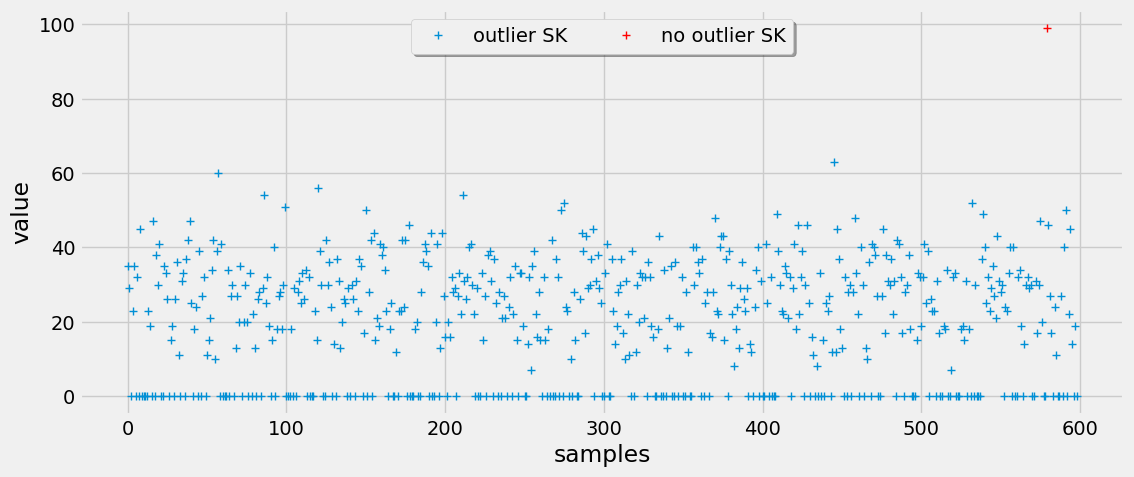

28 outliers in column TS


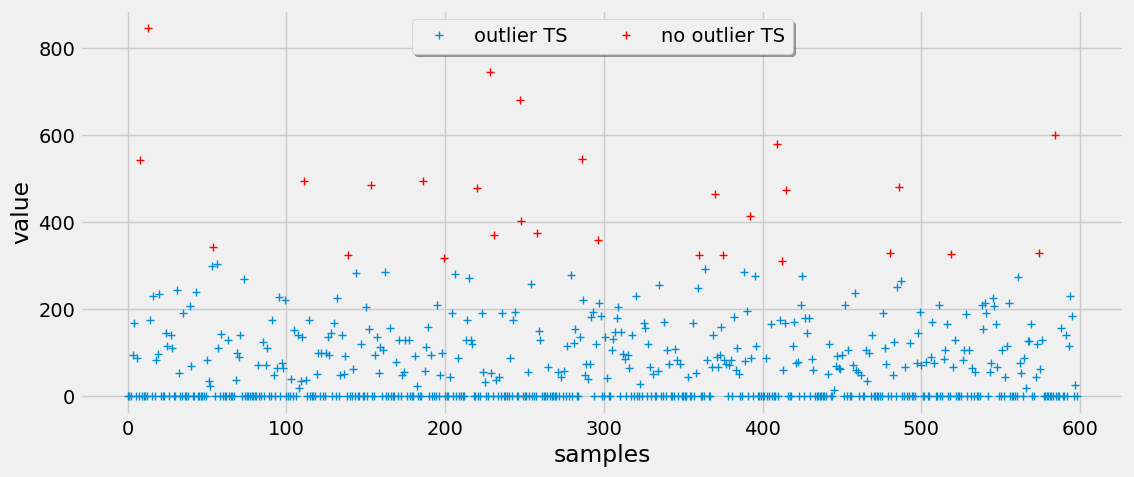

16 outliers in column M11


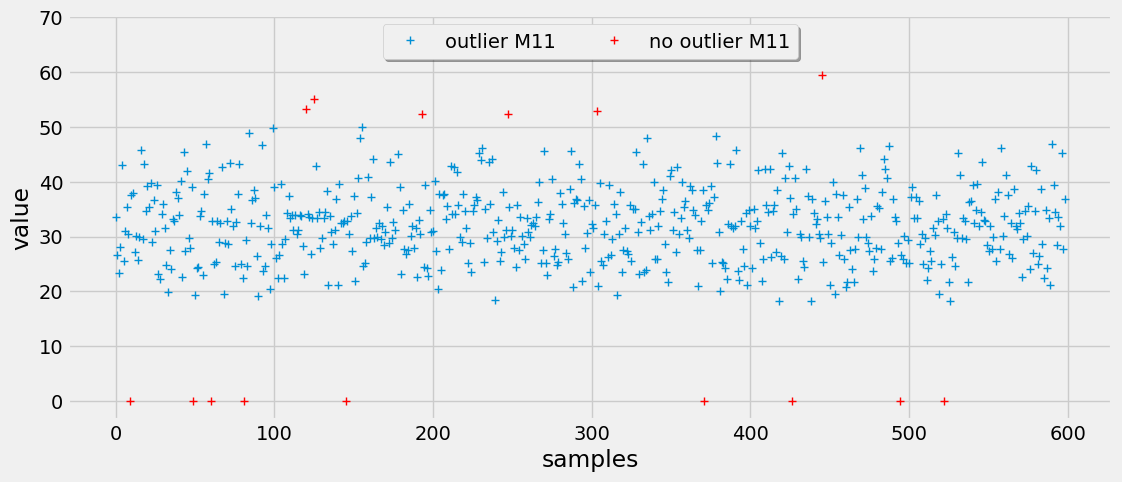

19 outliers in column BD2


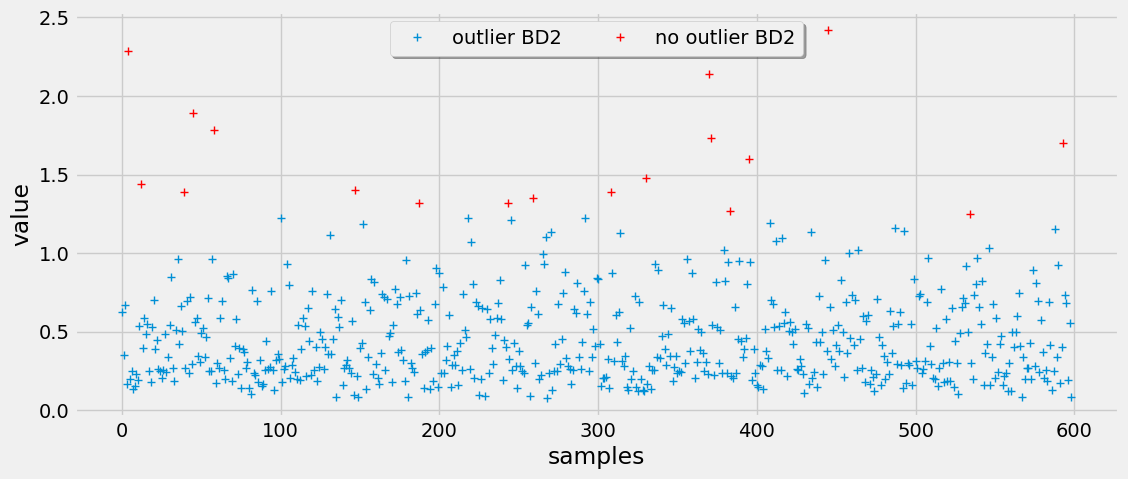

12 outliers in column Age


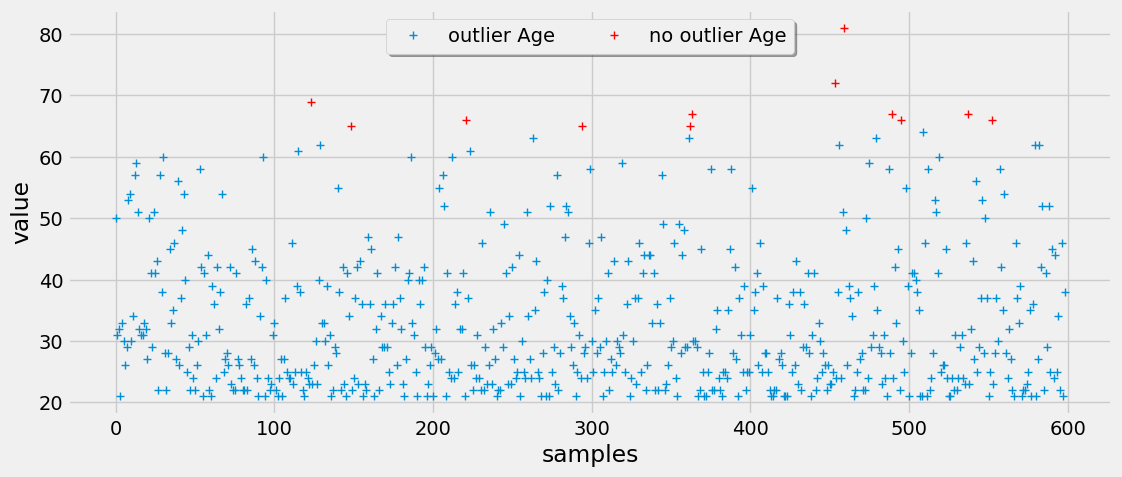

In [16]:
## plot outliers for each num variable using IQR method

for col in num_cols[1:]:
    data = mark_outliers_iqr(dataset=train_df, col=col)
    print(f"{data[col + '_outlier'].sum()} outliers in column {col}")
    plot_binary_outliers(dataset=data, col=col, outlier_col=col + "_outlier", reset_index=True)
    
    

- In some cases eg, PR, there seems to be clusters formed. 
- Let's investigate possible interaction effect with sepsis
- perhaps separating the data using the sepsis can help us to better deal with the outliers. 

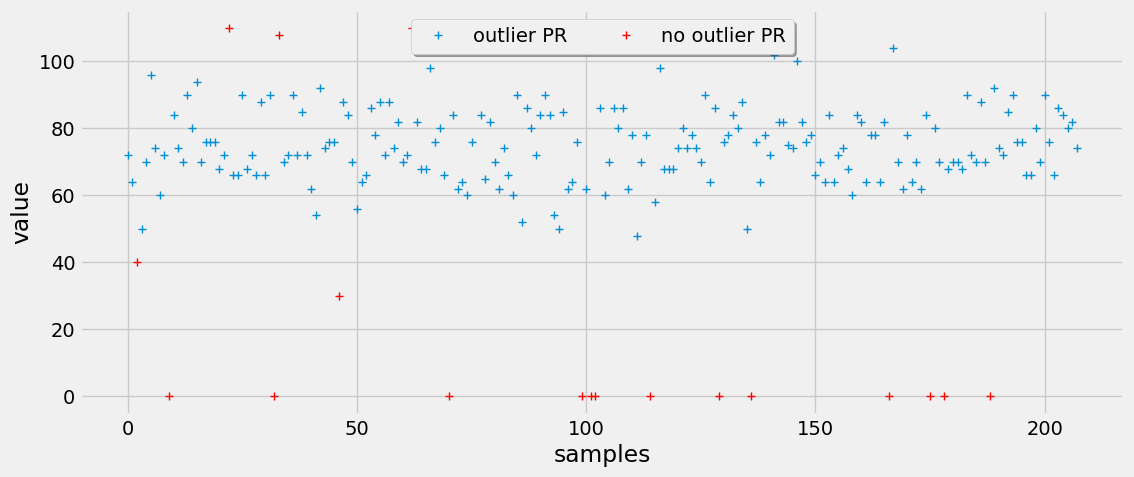

In [17]:
## plot the 2 classes of sepsis 

col = "PR" 
cls = "Positive"
data = mark_outliers_iqr(train_df[train_df["Sepssis"] == cls], col=col)
plot_binary_outliers(data, col=col, outlier_col=col + "_outlier", reset_index=True)

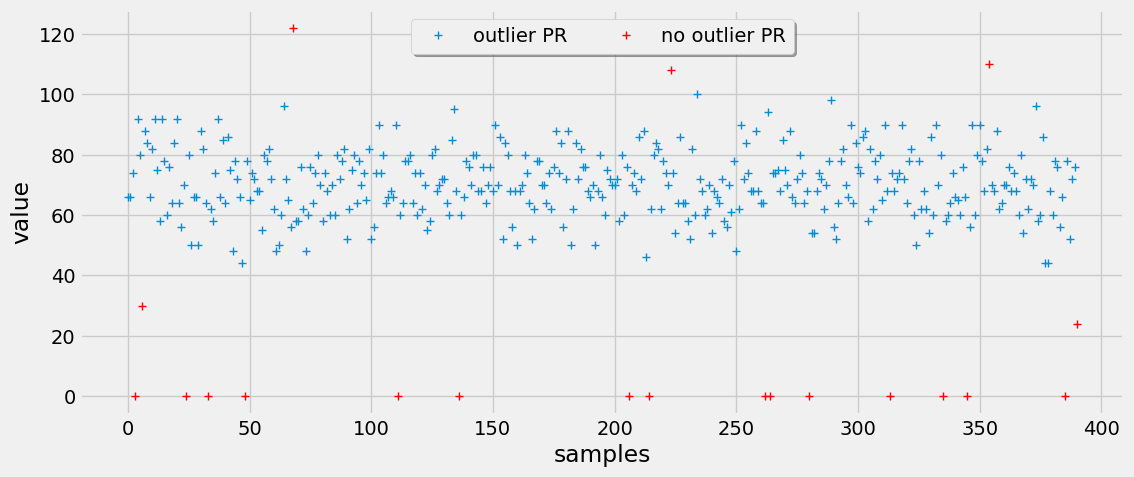

In [18]:
col = "PR" 
cls = "Negative"
data = mark_outliers_iqr(train_df[train_df["Sepssis"] == cls], col=col)
plot_binary_outliers(data, col=col, outlier_col=col + "_outlier", reset_index=True)

- the two classes of sepsis doesn't affect outlier locations. outliers are occur about equally for the two classes. 
- If the clusters were attributable to the the classes of Sepsis, then the outliers would represent important data points that reflect actual variation in the data and not anomalies or measurement errors

##    Data Cleaning 
There was no missing values in our data. So we handler outliers. 

- number of outliers are relatively small, and thus imputing outliers won't significantly affect feature distribution and we get to maintain our data size . 
- we impute using winsorization - a technique that involves setting outliers to be equal to some specified upper and lower bounds. 

In [19]:
train_df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [20]:
## define winsorization function

def winsorize_data(data: pd.DataFrame, cols: list) -> pd.DataFrame:
    
    winsorized_data = data.copy()
    
    for col in cols:
        for cls in ['Positive', 'Negative']:
        
            Q1 = data.loc[ (data["Sepssis"] == cls), col ].quantile(0.25)
            Q3 = data.loc[ (data["Sepssis"] == cls), col ].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            

            winsorized_data.loc[ (data["Sepssis"] == cls), col ] = np.clip(data.loc[ (data["Sepssis"] == cls), col ], lower_bound, upper_bound) 
    
    return winsorized_data

In [21]:
## winsorize data 

outliers_removed_df = winsorize_data(data=train_df, cols=num_cols)

In [22]:
def plot_boxplot(col):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4) , sharey=True)
    sns.boxplot(data=train_df, x=col, y="Sepssis", ax=axes[0] );
    sns.boxplot(data=outliers_removed_df, x=col, y="Sepssis", ax=axes[1] );
    axes[0].set_title("Before dealing with outliers")
    axes[1].set_title("After dealing with outliers");

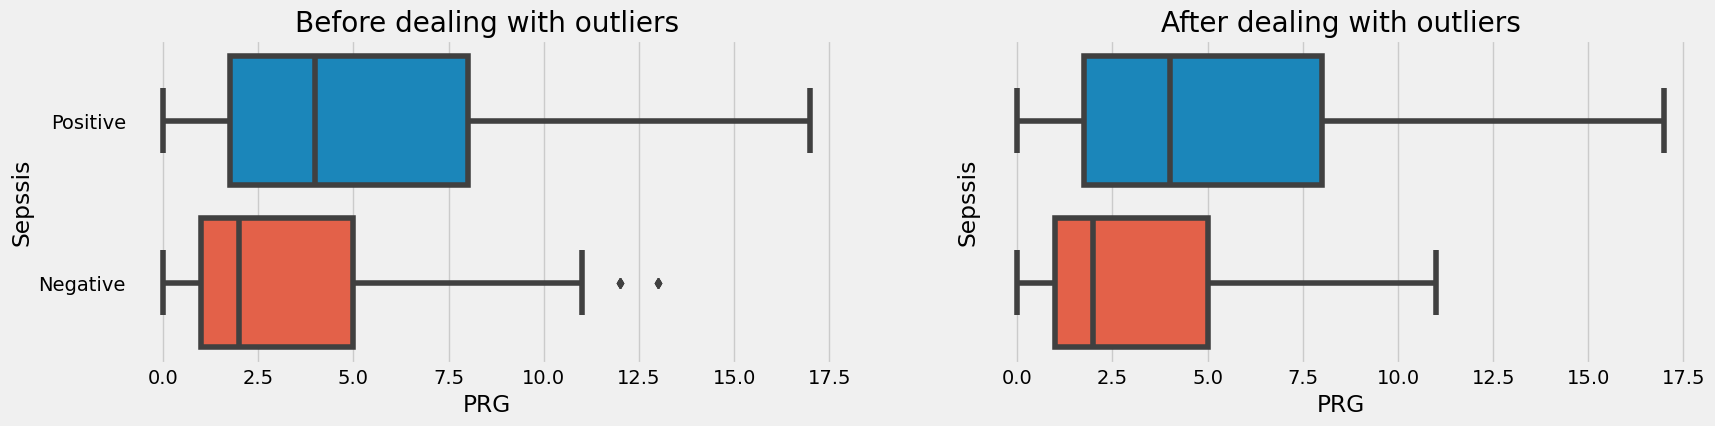

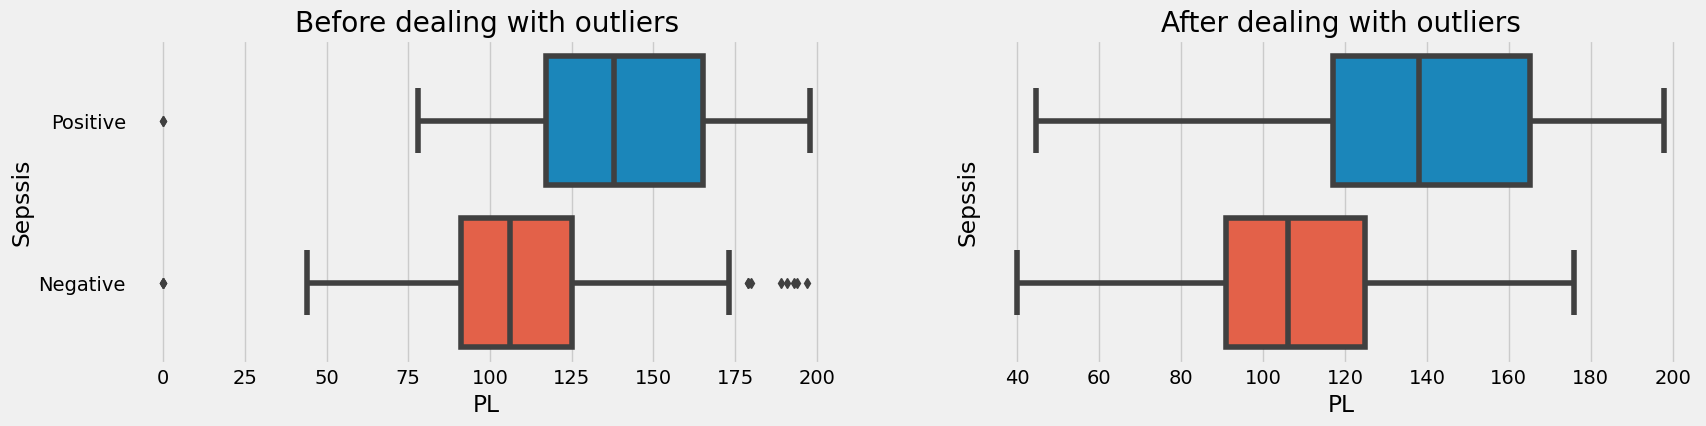

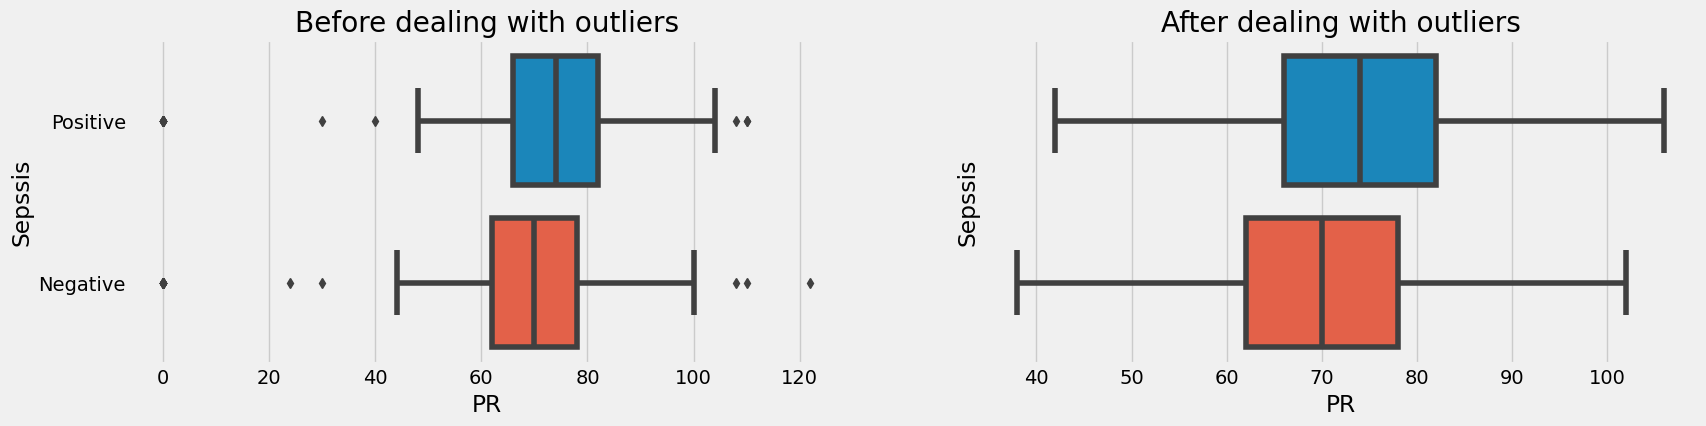

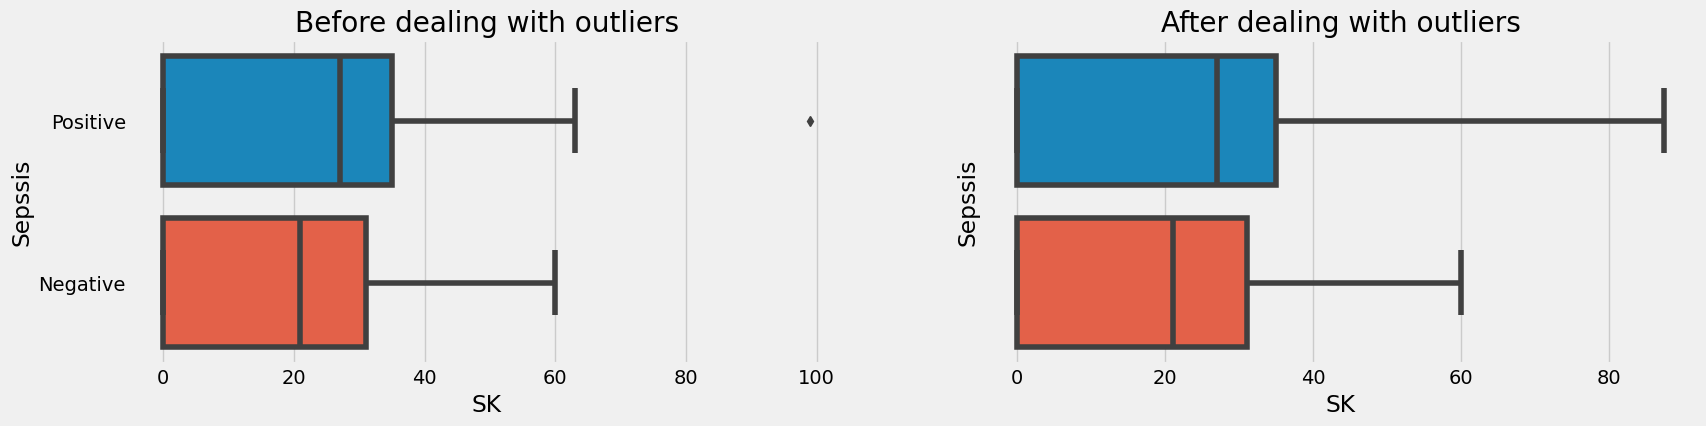

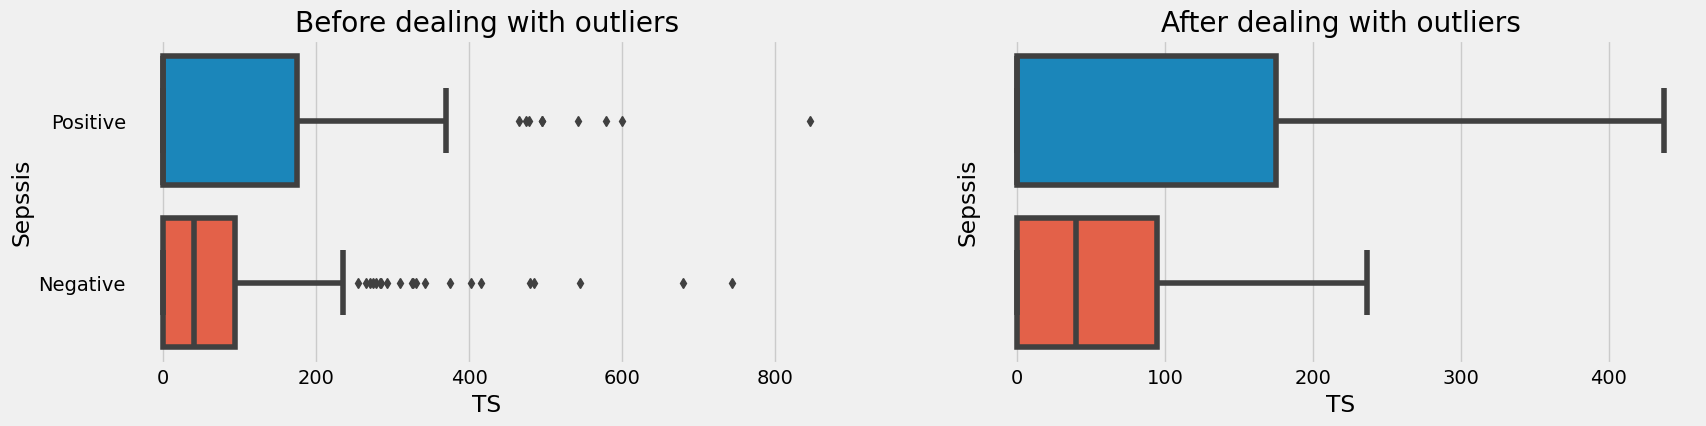

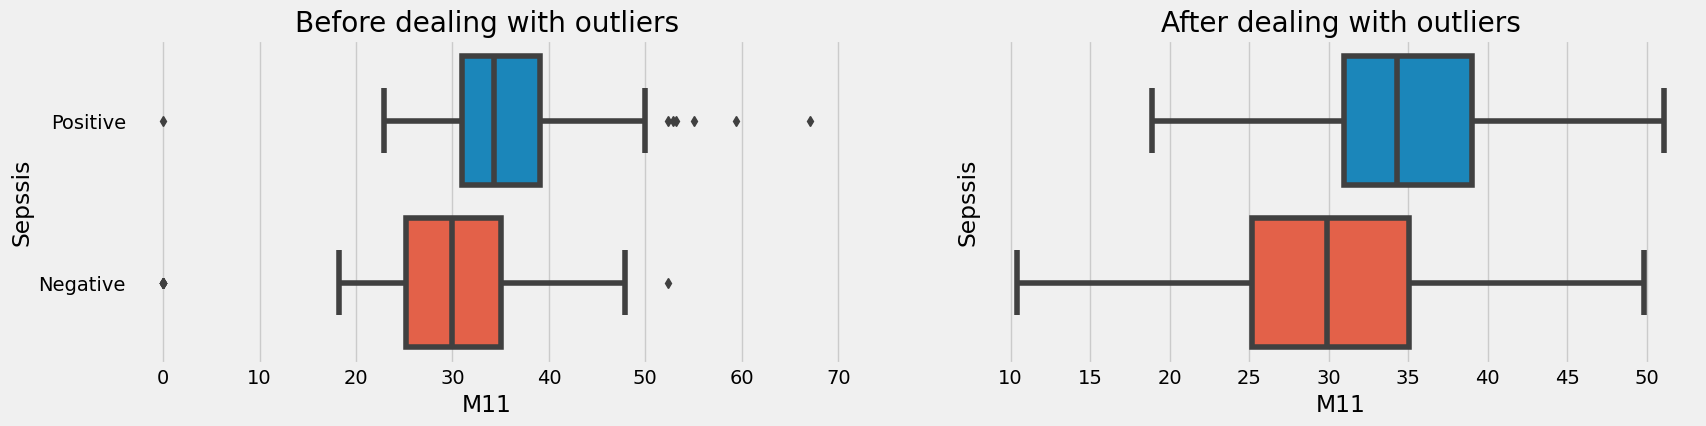

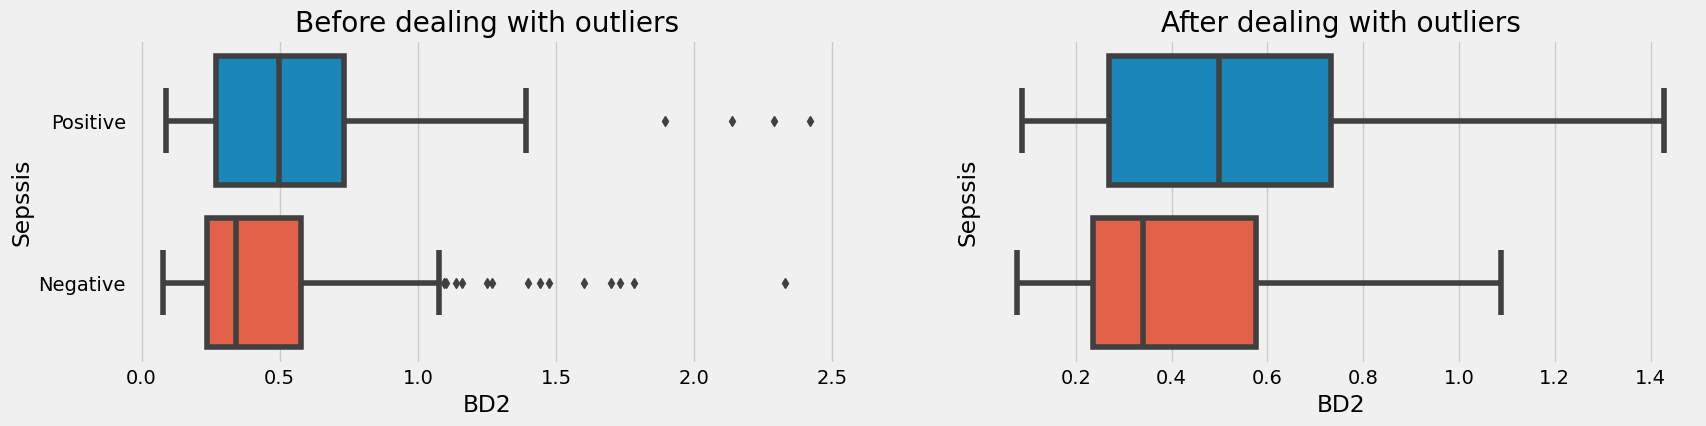

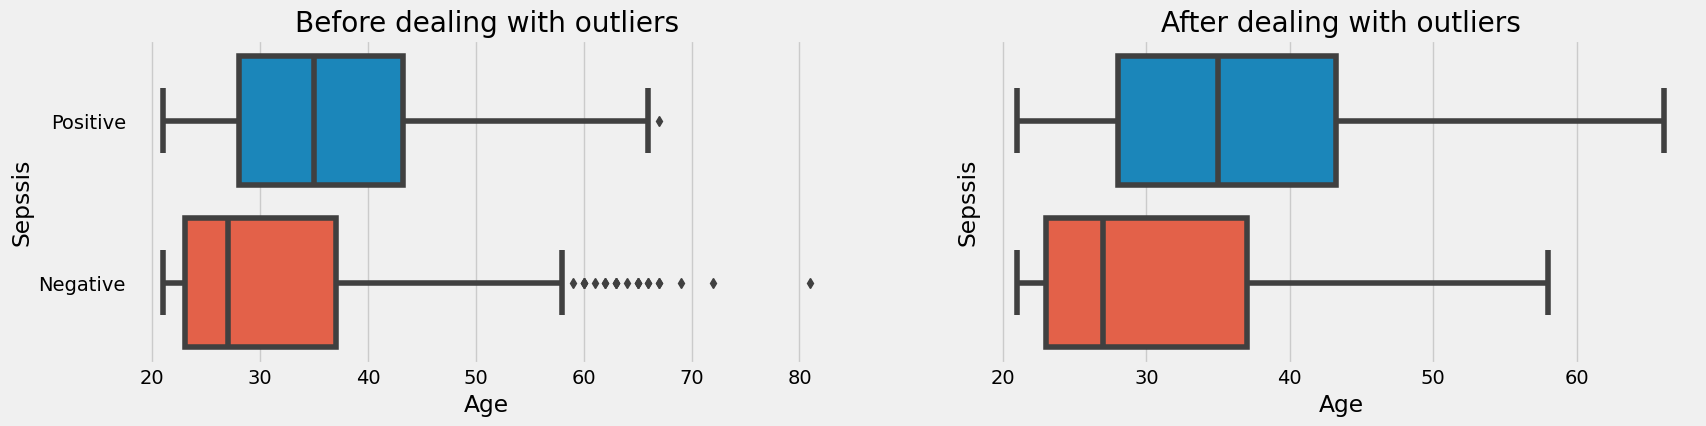

In [23]:
## plot outliers for each num variable using IQR method after imputing

for col in num_cols:
    plot_boxplot(col)

    

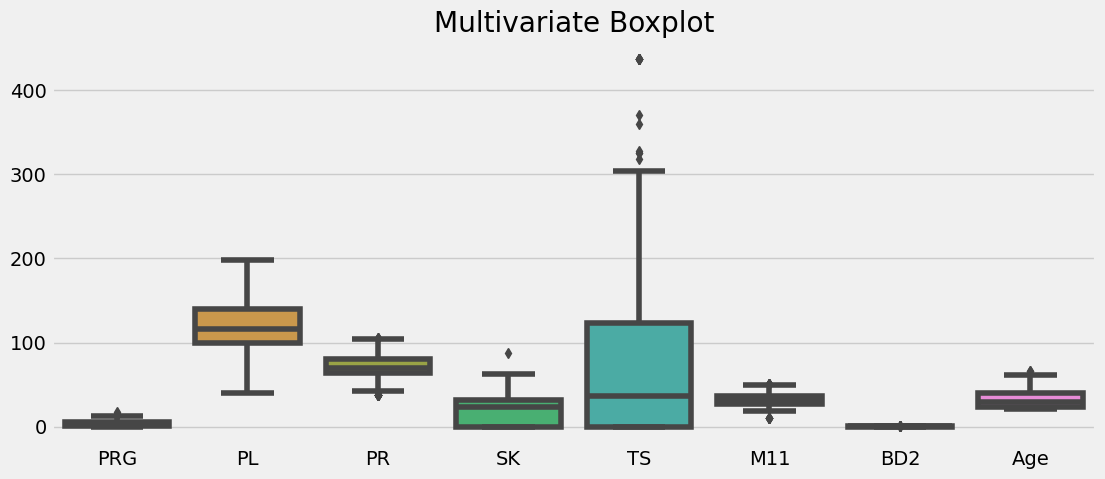

In [24]:
## check outliers 

sns.boxplot(outliers_removed_df[num_cols])
plt.title("Multivariate Boxplot");

- As may be expected, when the groups are put together, the presence of outliers are observed. 
- This is due to the heterogeneity of the two groups. 
- These are outliers reflects important variability in the data and need not to be imputed

In [25]:

outliers_removed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    float64
 3   PR         599 non-null    int64  
 4   SK         599 non-null    float64
 5   TS         599 non-null    float64
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    float64
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(6), int64(3), object(2)
memory usage: 51.6+ KB


In [26]:
## save cleaned data
outliers_removed_df.to_pickle("../data/interim/outliers_removed_df.pkl")


In [27]:
data = pd.read_pickle("../data/interim/outliers_removed_df.pkl").drop("ID", axis=1)
data.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,6,148.0,72,35.0,0.0,33.6,0.62700,50.0,0,Positive
1,1,85.0,66,29.0,0.0,26.6,0.35100,31.0,0,Negative
2,8,183.0,64,0.0,0.0,23.3,0.67200,32.0,1,Positive
3,1,89.0,66,23.0,94.0,28.1,0.16700,21.0,1,Negative
4,0,137.0,42,35.0,168.0,43.1,1.42875,33.0,1,Positive


##  Bivariate and Multivariate Analysis 
***Identifying patterns and Exploring Relationships***

### a . Correlation Analysis

***Correlation Heatmap***

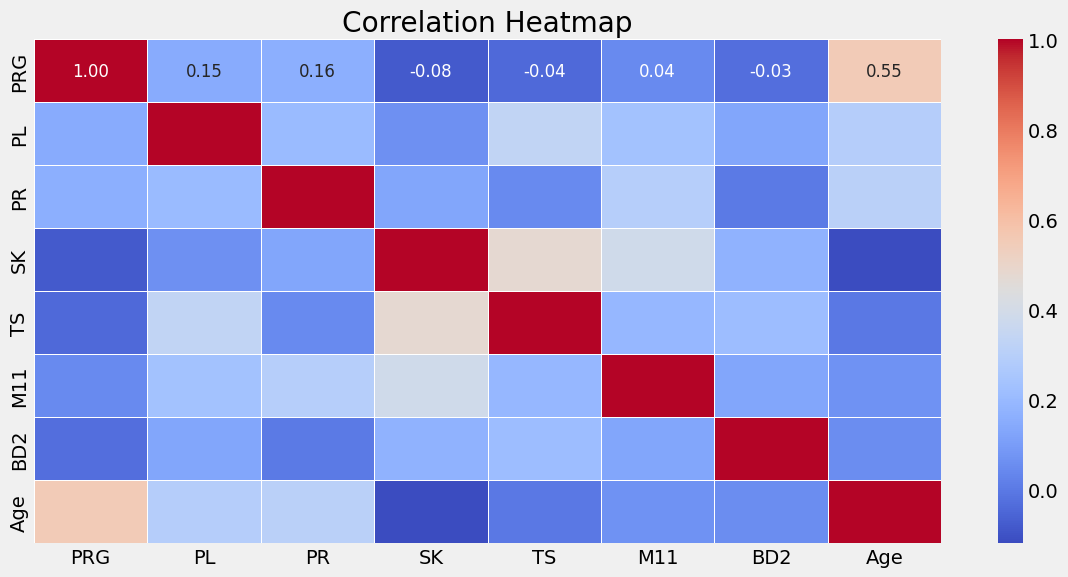

In [28]:
## Correlation heatmap
plt.rc("figure", autolayout=True)

plt.figure(figsize=(12, 6))
corr_matrix = data[num_cols].corr()
sns.heatmap(data=corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",  linewidths=0.5, annot_kws={"size": 12})
plt.title("Correlation Heatmap");


- Generally, features seem to have low correlation, which implies they are likely to provide unique information to a model 
- Also it may be easier to interpret individual effects of features. 
- Since the number of features are also relatively small, we can use all features and avoid overfitting. 

***Mutual information (MI)***

- A general-purpose metric the describes relationships in terms of uncertainty. The MI between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. 

- MI between two random variables is a non-negative value, which measures the dependency between the variables. 
- It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

- MI can't detect interaction effect. feature may be informative interacting with others but not so informative alone



In [29]:
## split data into feature matrix and target

X = data.copy()
y = X.pop("Sepssis") 

In [30]:
## preview split data

display(X.head())
y.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,6,148.0,72,35.0,0.0,33.6,0.62700,50.0,0
1,1,85.0,66,29.0,0.0,26.6,0.35100,31.0,0
2,8,183.0,64,0.0,0.0,23.3,0.67200,32.0,1
3,1,89.0,66,23.0,94.0,28.1,0.16700,21.0,1
4,0,137.0,42,35.0,168.0,43.1,1.42875,33.0,1


0    Positive
1    Negative
2    Positive
3    Negative
4    Positive
Name: Sepssis, dtype: object

In [31]:
## calculate mutual info scores

mi_scores = pd.Series(mutual_info_classif(X, y), 
                      name="MI Scores", 
                      index=X.columns).sort_values(ascending=False)
mi_scores

PL           0.153434
TS           0.140809
M11          0.121089
Age          0.069613
PR           0.048016
BD2          0.034158
PRG          0.029731
SK           0.024682
Insurance    0.000000
Name: MI Scores, dtype: float64

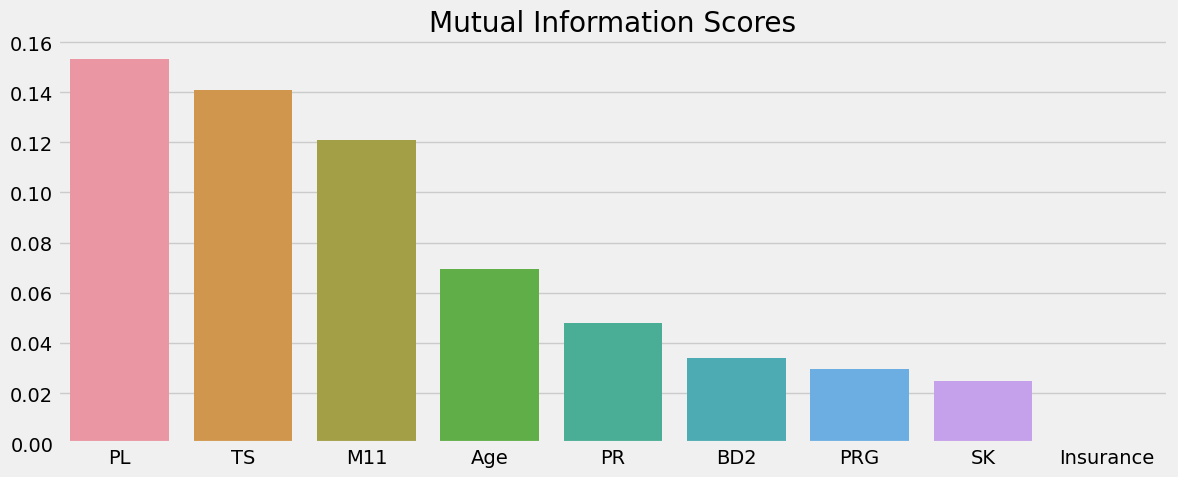

In [32]:
## visualize mi scores


sns.barplot(x=mi_scores.index,  y=mi_scores.values)
plt.title("Mutual Information Scores");

`PL -- Blodd Work Results-1` and `TS  -- Blood Work Result-3` exhibits the strongest relationship with 'Blood Poison'.  
- But does this mean a good predictive power of `Sepsis`?
- Let's compare the distribution of these features across the two classes of 'Blood Poison'
- Significant differences implies good predictive power of 'Blood Poison'

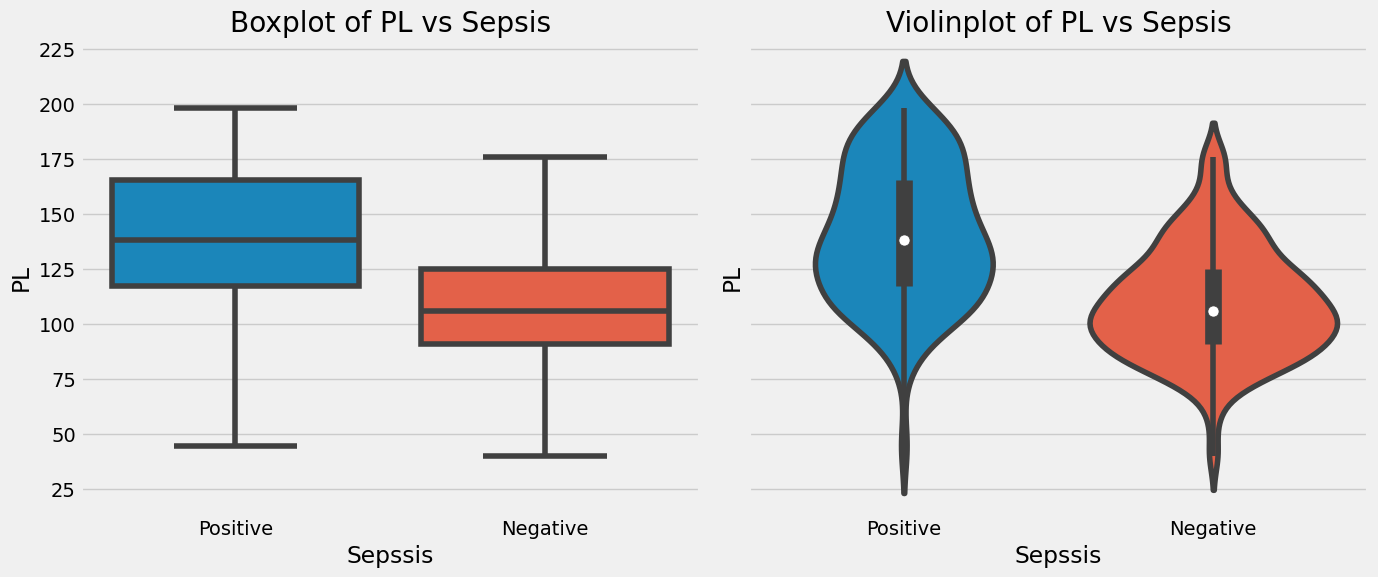

In [33]:
## violinplot and boxplot 
def box_violin_plot(col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True  )
    sns.boxplot(x="Sepssis", y=col, data=data, ax=axes[0])
    axes[0].set_title(f"Boxplot of {col} vs Sepsis")
    sns.violinplot(x="Sepssis", y=col, data=data, ax=axes[1])
    axes[1].set_title(f"Violinplot of {col} vs Sepsis");
    

box_violin_plot(col="PL")


- From the boxplox, the two class seems to have significantly different quartiles, and dispersion.  
- The violinplot shows that the two classes seem to have different distribution shape
- If these differences are statistically significant, then ML model will find these useful in predicting classes. 



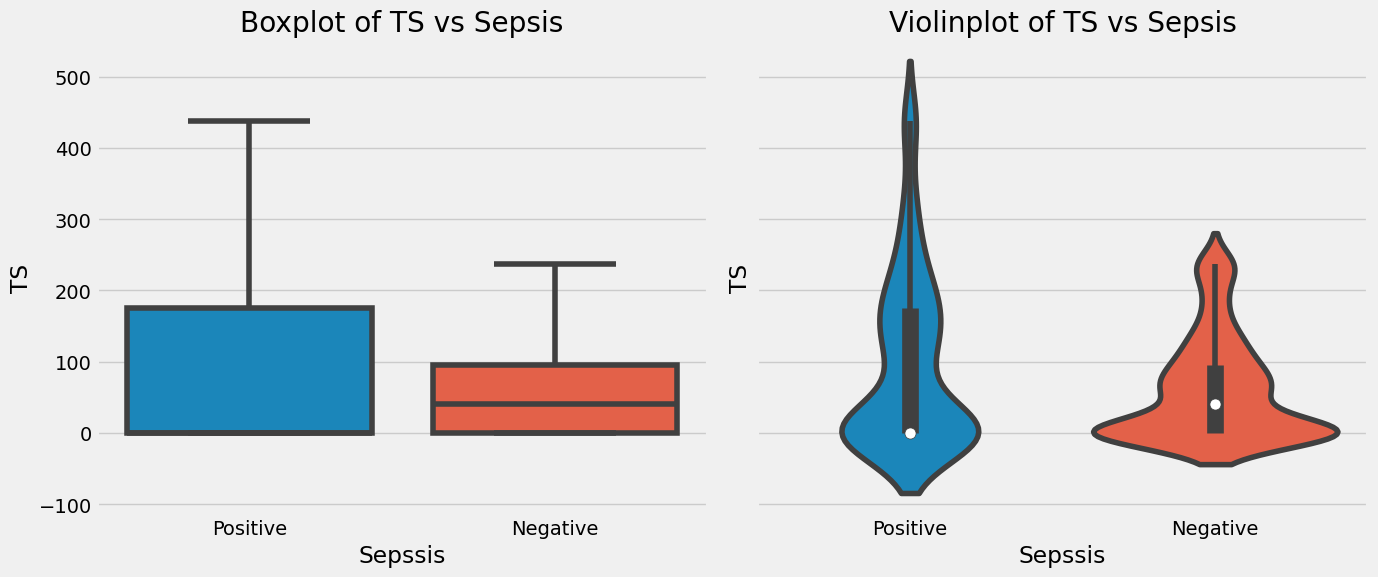

In [34]:
box_violin_plot(col="TS")

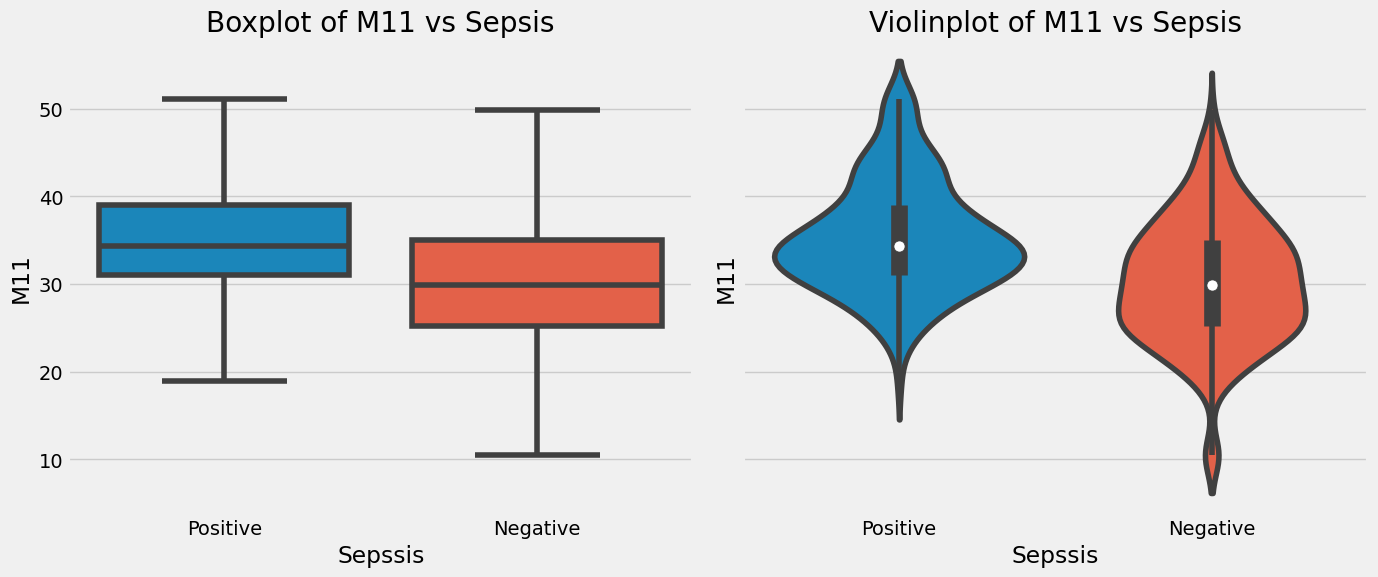

In [35]:
box_violin_plot(col="M11")

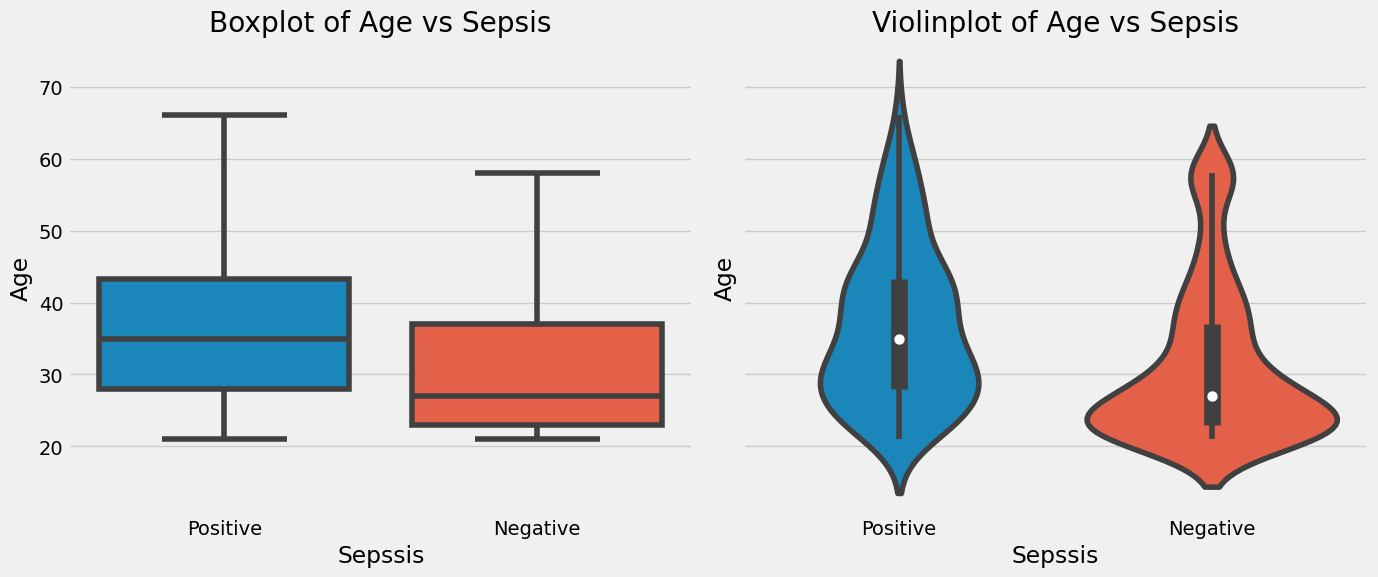

In [36]:
box_violin_plot(col="Age")

- Among variables with high MI Scores, there seems to be significant differences in the two classes of Sepssis
- These variables or some transformations of them is likely to have high predictive power.
- These have potential to improve model performance

### b . Interactions Effects



We analyse some interaction effects. from the correlation heatmap we see somehwat strong correlation between `Age` and `PRG` as well as `SK` and `TS`

***Pairplots***

From the correlation heatmap, we evaluate the discriminatory power of pairs of variables with high correlation 

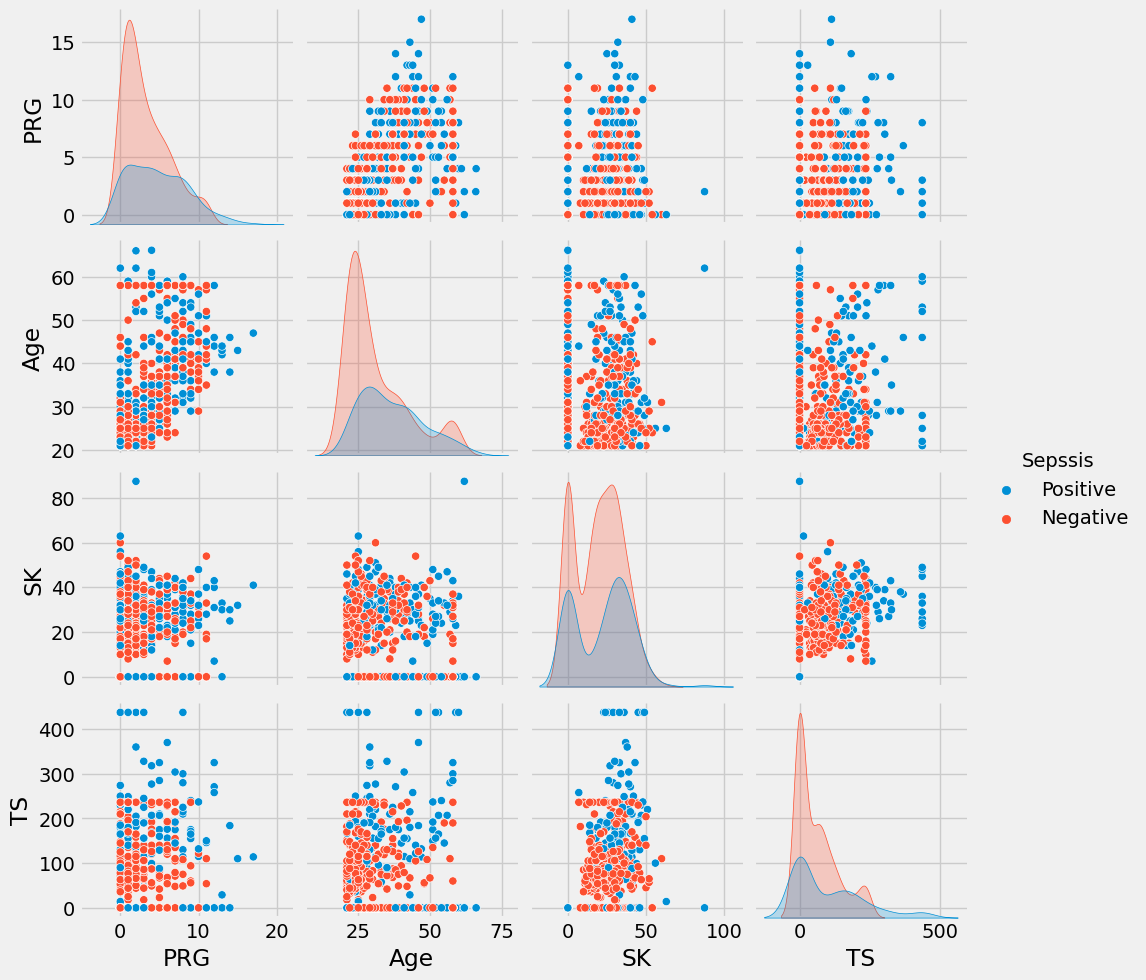

In [37]:
cols = ["PRG", "Age", "SK", "TS", "Sepssis"]

sns.pairplot(data[cols], hue="Sepssis");

- Among pairs of variables with correlation scores, there isn't clear clusters form
- This may mean that the pairs of variables have low discriminatory power. this is reflected in how the two classes of sepssis overlap in distribution
- we see high variability in the two classes making it difficult for clear clusters to be formed
- Effective feature engineering and systematic feature selection is essential to improve model performance

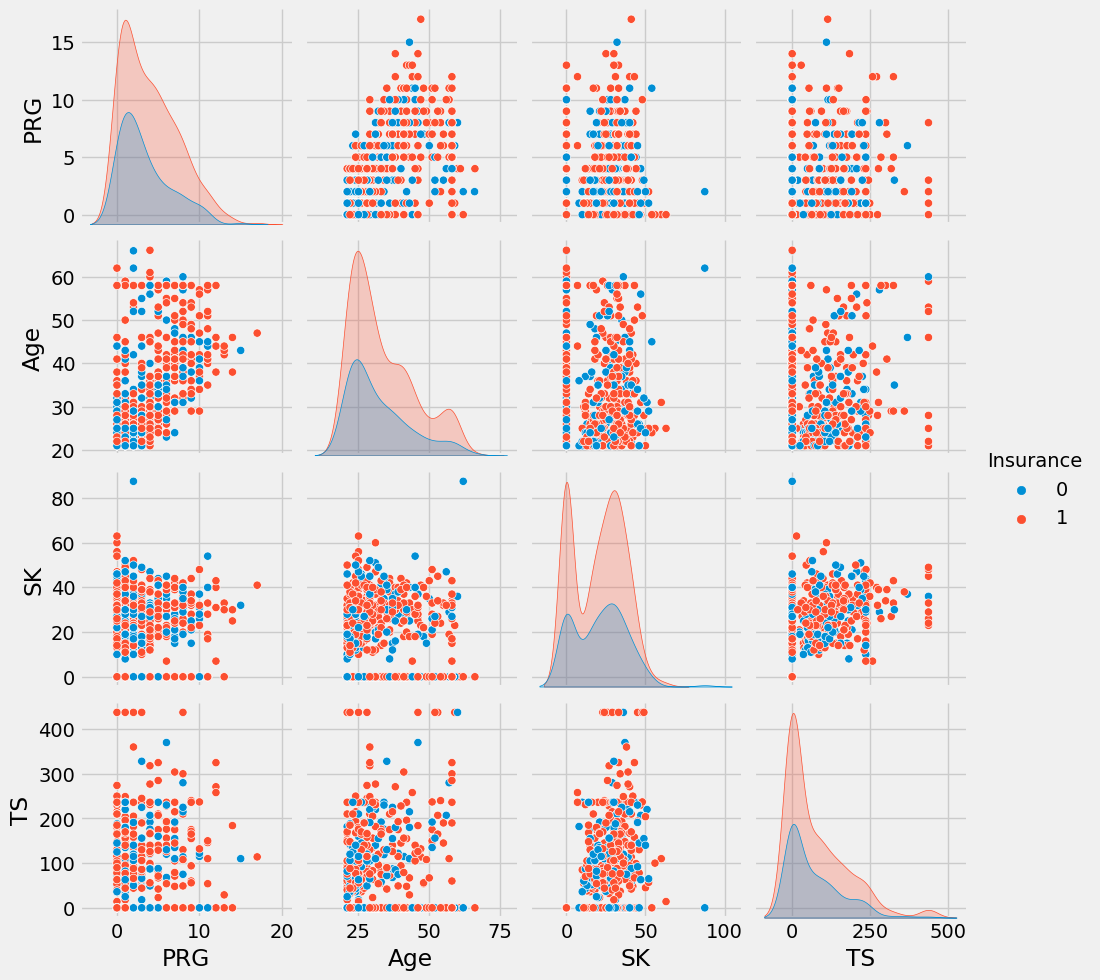

In [38]:
cols = ["PRG", "Age", "SK", "TS", "Insurance"]

sns.pairplot(data[cols], hue="Insurance");

- no observable clusters when `Insurance` is used as hue either
- `Insurance` doesn't have interaction effection and also have low MI Score
- `Insurance` will likely not improve model performance as it has low predictive power as well as discriminatory power

In [39]:
# fig, ax = plt.subplots(figsize=(10, 6))

def plot_lm(col1, col2, hue):
    sns.lmplot(x=col1, y=col2, hue=hue, data=data)

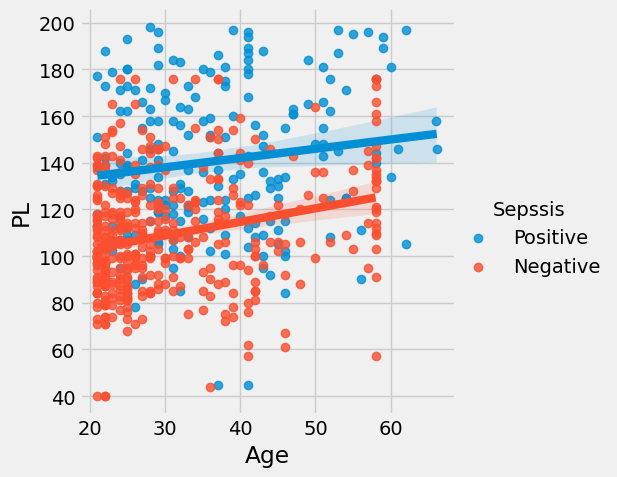

In [ ]:
    
plot_lm(col1="Age", col2="PL", hue="Blood Poison")

### c . Dimentionality Reduction 

***Principal Component Analysis***

PCA is a technique used in machine learning to reduce the complexity of data by transforming the data into a new set of variables called principal components. This transformation is done in such a way that the new set of variables captures the most amount of information from the original data set, while reducing the number of variables necessary. This helps to reduce the complexity of the data and make it easier to analyze and make predictions from.

<img src="../reports/img/pca.PNG" width="40%" height="20%">

In [43]:
## Define PCA class to streamline work. 
# Source: Machine Learning for the Quantified Self, Mark Hoogendoorn and Burkhardt Funk (2017), Chap 3 (modified for my purpose)

# Class for Principal Component Analysis. We can only apply this when we do not have missing values (i.e. NaN).
# For this we have to impute these first, be aware of this.


class PrincipalComponentAnalysis:

    def __init__(self):
        self.pca = None
        self.scaler = None

    def normalize_dataset(self, data_table, columns):
        dt_norm = copy.deepcopy(data_table)
        
        self.scaler = MinMaxScaler()
        dt_norm[columns] = pd.DataFrame(self.scaler.fit_transform(data[columns]), columns=columns)
        return dt_norm

    # Perform the PCA on the selected columns and return the explained variance.
    def determine_pc_explained_variance(self, data_table, cols):

        # Normalize the data first.
        dt_norm = self.normalize_dataset(data_table, cols)

        # perform the PCA.
        self.pca = PCA(n_components=len(cols))
        self.pca.fit(dt_norm[cols])
        # And return the explained variances.
        return self.pca.explained_variance_ratio_

    # Apply a PCA given the number of components we have selected.
    # We add new pca columns.
    def apply_pca(self, data_table, cols, number_comp):

        # Normalize the data first.
        dt_norm = self.normalize_dataset(data_table, cols)

        # perform the PCA.
        self.pca = PCA(n_components=number_comp)
        self.pca.fit(dt_norm[cols])

        # Transform our old values.
        new_values = self.pca.transform(dt_norm[cols])

        # And add the new ones:
        for comp in range(0, number_comp):
            data_table["pca_" + str(comp + 1)] = new_values[:, comp]

        return data_table



In [44]:
## experiment with actual data and data with removed outliers


df_pca = data.copy() 
pca_instance = PrincipalComponentAnalysis() 

In [45]:
pca_values = pca_instance.determine_pc_explained_variance(data_table=df_pca, cols=num_cols)
pca_values

array([0.27799045, 0.22854451, 0.12597479, 0.10873626, 0.09092463,
       0.0710141 , 0.05528322, 0.04153205])

- 8 components as expected. since we have 8 numerical columns
- But the objective of dimensionality reduction is to reduce the number of variables. 
- We estimate the optimal number of components to use using the ***Elbow Technique***

***Determine Optimal number of Principal Components -- Elbow Technique***

The elbow technique is a method used to determine the optimal number of components to use when conducting a PCA. It works by testing multiple different component numbers and then evaluating the variance captured by each component number. The optimal component number is then chosen as the number of components that capture the most variance while also not incorporating too many components. This is done by plotting the variance captured against the component number and then selecting the point at which the rate of change in variance diminishes (the "elbow"), as this is typically the point at which adding more components does not significantly improve the analysis.

<img src="../reports/img/elbow.png" width="40%" height="20%">


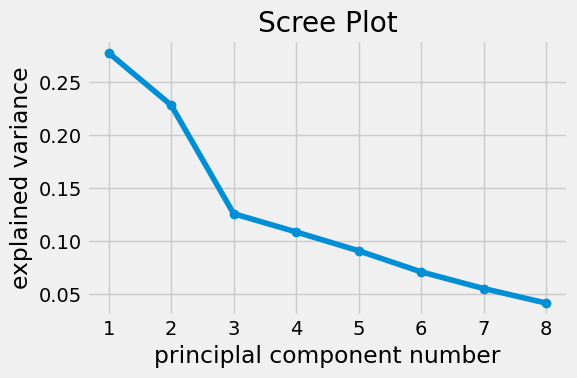

In [46]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(num_cols) + 1), pca_values, marker="o")
plt.xlabel("principlal component number")
plt.ylabel("explained variance")
plt.title("Scree Plot");


- By the elbow method, we choose 3 components. 
- Adding more components may result in overfitting or caturing noise in the data. 

In [47]:
def total_ev(pca_values, k):
    print(f"total ev with {k} components: {pca_values[:k].sum() * 100:.2f}%")

In [48]:
total_ev(pca_values, 2)
total_ev(pca_values, 3)
total_ev(pca_values, 4)
total_ev(pca_values, 5)
total_ev(pca_values, 6)

total ev with 2 components: 50.65%
total ev with 3 components: 63.25%
total ev with 4 components: 74.12%
total ev with 5 components: 83.22%
total ev with 6 components: 90.32%


| Dataset | StandardScaler | RobustScaler | MinMaxScaler |PCA Components|
|---------|----------------|--------------|--------------|------------------------|
| Data with outliers    |       61.55%        |       62.47%       |      63.81%       |          3          |
| Data without outliers       |       61.55%        |      62.47%       |      63.25%       |           3            |         
| Data with outliers    |        72.20%        |     73.62%      |      74.34%       |          4          |
| Data without outliers       |       72.20%        |   73.62%         |      74.12%       |           4            |         


- for visualization we can settle for less. 
- but to improve predictive power, we may need more. 

***Apply PCA***

In [49]:
df_pca = pca_instance.apply_pca(df_pca, num_cols, 5)
df_pca

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis,pca_1,pca_2,pca_3,pca_4,pca_5
0,6,148.0,72,35.0,0.0,33.6,0.62700,50.0,0,Positive,0.386893,-0.101525,0.098509,-0.084066,0.016778
1,1,85.0,66,29.0,0.0,26.6,0.35100,31.0,0,Negative,-0.270314,-0.104672,-0.027902,-0.069415,0.111628
2,8,183.0,64,0.0,0.0,23.3,0.67200,32.0,1,Positive,0.124410,-0.196245,0.289869,0.155440,-0.306461
3,1,89.0,66,23.0,94.0,28.1,0.16700,21.0,1,Negative,-0.386966,0.035793,-0.166647,0.093462,0.082263
4,0,137.0,42,35.0,168.0,43.1,1.42875,33.0,1,Positive,0.026713,0.604190,0.612364,-0.124143,-0.009944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,6,123.0,72,45.0,230.0,33.6,0.73300,34.0,0,Negative,0.214150,0.383508,0.079020,0.059297,0.228420
595,0,188.0,82,14.0,185.0,32.0,0.68200,22.0,1,Positive,0.030605,0.407243,0.001980,0.085342,-0.462084
596,0,67.0,76,0.0,0.0,45.3,0.19400,46.0,1,Negative,-0.010589,-0.293146,-0.210836,-0.248313,0.036264
597,1,89.0,38,19.0,25.0,27.8,0.55900,21.0,0,Negative,-0.521076,0.013073,0.265686,0.086784,0.098005


In [50]:
df_pca.to_pickle("../data/interim/df_pca.pkl")

In [51]:
df_pca = pd.read_pickle("../data/interim/df_pca.pkl")
df_pca.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis,pca_1,pca_2,pca_3,pca_4,pca_5
0,6,148.0,72,35.0,0.0,33.6,0.62700,50.0,0,Positive,0.386893,-0.101525,0.098509,-0.084066,0.016778
1,1,85.0,66,29.0,0.0,26.6,0.35100,31.0,0,Negative,-0.270314,-0.104672,-0.027902,-0.069415,0.111628
2,8,183.0,64,0.0,0.0,23.3,0.67200,32.0,1,Positive,0.124410,-0.196245,0.289869,0.155440,-0.306461
3,1,89.0,66,23.0,94.0,28.1,0.16700,21.0,1,Negative,-0.386966,0.035793,-0.166647,0.093462,0.082263
4,0,137.0,42,35.0,168.0,43.1,1.42875,33.0,1,Positive,0.026713,0.604190,0.612364,-0.124143,-0.009944


### d . Cluster Analysis
***K-Means Clustering***

K-means clustering is an unsupervised machine learning algorithm used to group data into clusters based on similarity. It randomly initializes k points (centroids) in the data space, calculates the distance between each data point and each centroid, and assigns each point to its closest centroid. K-means clustering is a popular feature engineering technique used in many applications such as identifying the most important features in a dataset, segmenting customers into different clusters based on their purchase behaviors, anomaly detection, and image compression.

The Elbow Method, also known as the “elbow curve technique” , is again used to determine the optimal number of clusters for a given dataset. It plots the Inertia (sum of squared distances of samples to their closest cluster center) for each k (number of clusters) against k and looks for the “elbow” point in the plot; this point represents the optimal number of clusters. The elbow method works by looping through different values of k and calculating the sum of squared errors for each iteration.

In [52]:
## make a copy of data
df_cluster = df_pca.copy()

- Since K-means is a distance based algo, we normalize the data

In [53]:
## normalize data 

scaler = MinMaxScaler()
df_cluster[num_cols] = pd.DataFrame(scaler.fit_transform(df_cluster[num_cols]), columns=num_cols)
df_cluster


,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis,pca_1,pca_2,pca_3,pca_4,pca_5
0,0.352941,0.683544,0.500000,0.400000,0.000000,0.569760,0.406441,0.642659,0,Positive,0.386893,-0.101525,0.098509,-0.084066,0.016778
1,0.058824,0.284810,0.411765,0.331429,0.000000,0.397664,0.202110,0.221607,0,Negative,-0.270314,-0.104672,-0.027902,-0.069415,0.111628
2,0.470588,0.905063,0.382353,0.000000,0.000000,0.316533,0.439756,0.243767,1,Positive,0.124410,-0.196245,0.289869,0.155440,-0.306461
3,0.058824,0.310127,0.411765,0.262857,0.214857,0.434542,0.065889,0.000000,1,Negative,-0.386966,0.035793,-0.166647,0.093462,0.082263
4,0.000000,0.613924,0.058824,0.400000,0.384000,0.803319,1.000000,0.265928,1,Positive,0.026713,0.604190,0.612364,-0.124143,-0.009944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,0.352941,0.525316,0.500000,0.514286,0.525714,0.569760,0.484916,0.288089,0,Negative,0.214150,0.383508,0.079020,0.059297,0.228420
595,0.000000,0.936709,0.647059,0.160000,0.422857,0.530424,0.447159,0.022161,1,Positive,0.030605,0.407243,0.001980,0.085342,-0.462084
596,0.000000,0.170886,0.558824,0.000000,0.000000,0.857406,0.085878,0.554017,1,Negative,-0.010589,-0.293146,-0.210836,-0.248313,0.036264
597,0.058824,0.310127,0.000000,0.217143,0.057143,0.427167,0.356098,0.000000,0,Negative,-0.521076,0.013073,0.265686,0.086784,0.098005


In [54]:
#experiment with differnt column sets, number of clusters and inertias

def optimal_cluster_calculator( cluster_columns):
    
    k_values = range(2, 10)
    inertias = []

    for k in k_values:
        subset = df_cluster[cluster_columns]
        kmeans_instance = KMeans(n_clusters=k, n_init=20, random_state=42)
        kmeans_instance.fit(subset)
        inertias.append(round(kmeans_instance.inertia_, 2))
        
    plt.figure(figsize =(6,4))
    plt.plot(k_values, inertias, marker="o")
    plt.xlabel("numbr of clustrs(k)")
    plt.ylabel("Sum of Squared distances")
    plt.title(f"Scree Plot {cluster_columns}");
    
    print(inertias)
    

We cluster based on some set of clumns: 

- **Set 1 (Highest MI Scores): ["PL", "TS", "M11"]**

    Features with highest MI Scores. they are the features sepsis depends on the most according the MI metric

- **Set 2 (Blood Test Results and Body Mass Index): ["PL", "SK", "TS", "BD2", "M11"]**

    Blood test results can provide insights into a patient's physiological state, such as hormone levels, blood cell counts, or metabolic markers. Combining these with BMI can help identify clustrs of patients based on their metabolic health or specific blood profile characteristics

- **Set 3(Blood Test Results): ["PL", "SK", "TS", "BD2", "]**  combining all blood work results (PL, SK, TS, BD2) can provide a detailed profile of patients' physiological markers.

- **Set 4(Glucose Levels and Blood Pressure): ["PRG", "PR"]**

    Combining plasma glucose levels (PRG) with blood pressure (PR) can be insightful for clustering patients based on potential risk factors related to metabolic disorders or cardiovascular health.

- **Set 5 (Blood Test Results and Age): ["PL", "SK", "Age]**

    Analyzing blood test results (PL, SK) in conjunction with patients' age can reveal age-related patterns in blood markers. This set can be particularly useful for identifying clusters related to age-related health conditions or different physiological stages across age groups.

**Set 6 (Principal Components)**
    
    PCA can retain important information for clustering.

NB: The above sets were continuously refined based on outputs

In [55]:

cluster_columns1 = ["PRG", "PR"]
cluster_columns2 = ["PRG", "PR", "M11"]
cluster_columns3 = ["PRG", "PR", "Age"]
 
clusters = [cluster_columns1, 
            cluster_columns2, 
            cluster_columns3, 
            ]

Inertia for each k for cluster_columns1(['PRG', 'PR']):
[27.98, 18.32, 14.29, 11.56, 9.63, 8.18, 7.28, 6.45]

Inertia for each k for cluster_columns2(['PRG', 'PR', 'M11']):
[45.75, 34.14, 29.65, 25.91, 23.44, 21.18, 19.34, 17.67]

Inertia for each k for cluster_columns3(['PRG', 'PR', 'Age']):
[43.82, 34.61, 27.9, 24.11, 21.2, 19.07, 17.31, 16.04]



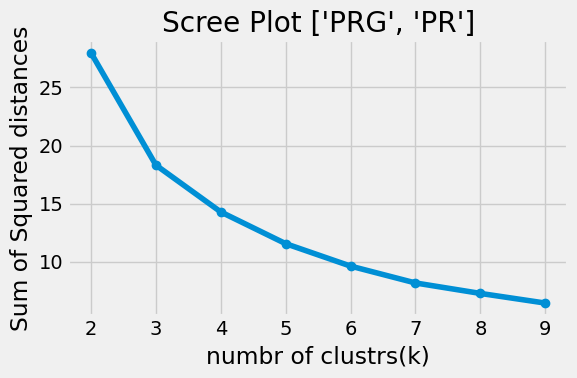

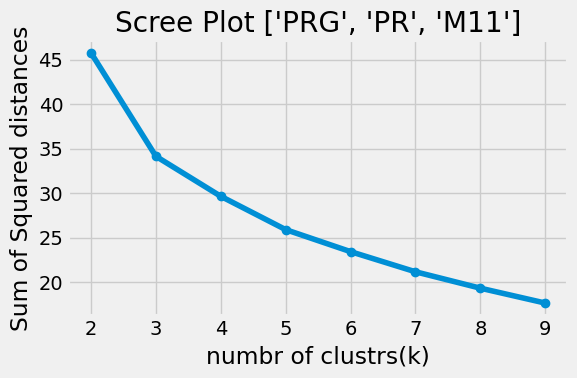

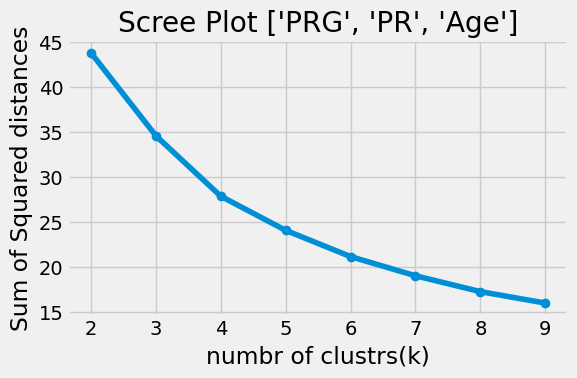

In [56]:
for i, cluster in enumerate(clusters):
    print(f"Inertia for each k for cluster_columns{i+1}({cluster}):")
    optimal_cluster_calculator(cluster) 
    print()

- cluster_columns4(['PRG', 'PR']) happens to be the best columns to perform the cluster on based on inertia
- we visualize the clusters to decide on how many clusters to use. 

In [57]:
kmeans_instance = KMeans(n_clusters=5, n_init=20, random_state=42)
df_cluster["Cluster"] = kmeans_instance.fit_predict(df_cluster[["PRG", "PR"]])
df_cluster.head()


,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis,pca_1,pca_2,pca_3,pca_4,pca_5,Cluster
0,0.352941,0.683544,0.500000,0.400000,0.000000,0.569760,0.406441,0.642659,0,Positive,0.386893,-0.101525,0.098509,-0.084066,0.016778,2
1,0.058824,0.284810,0.411765,0.331429,0.000000,0.397664,0.202110,0.221607,0,Negative,-0.270314,-0.104672,-0.027902,-0.069415,0.111628,0
2,0.470588,0.905063,0.382353,0.000000,0.000000,0.316533,0.439756,0.243767,1,Positive,0.124410,-0.196245,0.289869,0.155440,-0.306461,2
3,0.058824,0.310127,0.411765,0.262857,0.214857,0.434542,0.065889,0.000000,1,Negative,-0.386966,0.035793,-0.166647,0.093462,0.082263,0
4,0.000000,0.613924,0.058824,0.400000,0.384000,0.803319,1.000000,0.265928,1,Positive,0.026713,0.604190,0.612364,-0.124143,-0.009944,4


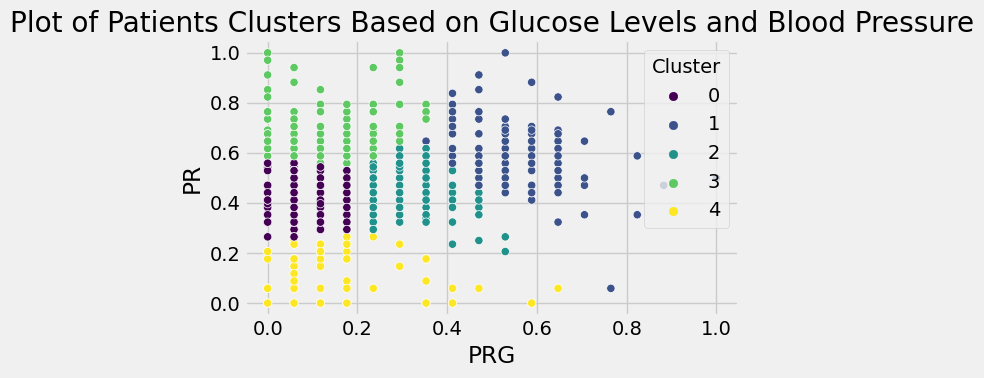

In [58]:
## plot clusters
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_cluster, x="PRG", y="PR", hue="Cluster", palette="viridis")
plt.title("Plot of Patients Clusters Based on Glucose Levels and Blood Pressure");

- From the way the clusters do not overlap, we can suspect this will be a good feature for our ML model 

In [59]:
df_cluster.to_pickle("../data/interim/df_cluster.pkl")

## 4 . Make and Test Hypothesis

We test a refined version of the initial hypothesis 

Null Hypothesis (H0): There is NO SIGNIFICANT DIFFERENCE in the means of PL(Blood Work Result-1) and TS(Blood Work Result-3) between patients with positive sepsis and patients with negative sepsis.

Alternative Hypothesis (H1): There is A SIGNIFICANT DIFFERENCE in the means of PL(Blood Work Result-1) and TS(Blood Work Result-3) between patients with positive sepsis and patients with negative sepsis.



### a. Assumptions and Test Selection

- Both normality and homoscedasticity -- use independent t-test
- only normality -- use welsh's t-test (robust to the assumption of homoscedasticity)
- no normality -- use Mann-Whitney U test ( Non-parametric)

***Normality inspection***

In [61]:
## define function to visualize distribution and qqplot

def kde_qqplot(data: pd.Series, col: list, group_name: str):
    _, ax = plt.subplots( figsize=(8, 4))
    sns.kdeplot(data=data, fill=True, ax=ax)
    ax.set_title(f"Density plot of {group_name}");
    
    pplot(pd.DataFrame(data, columns=col), x=col[0], y=norm, 
        kind="qq", aspect=2, height=4, display_kws={"identity":True})
    plt.title(f"Q-Q plot of {group_name}");

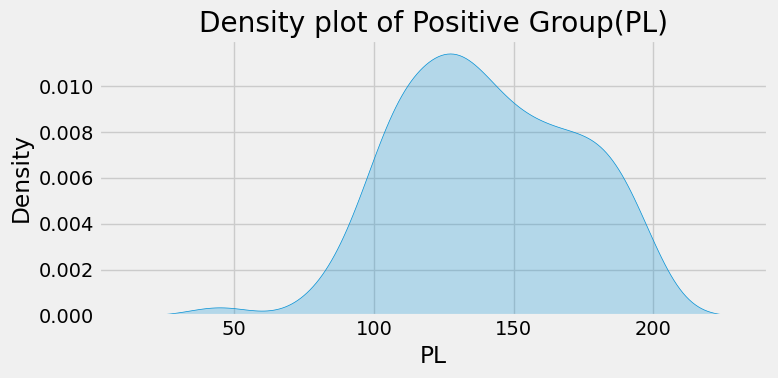

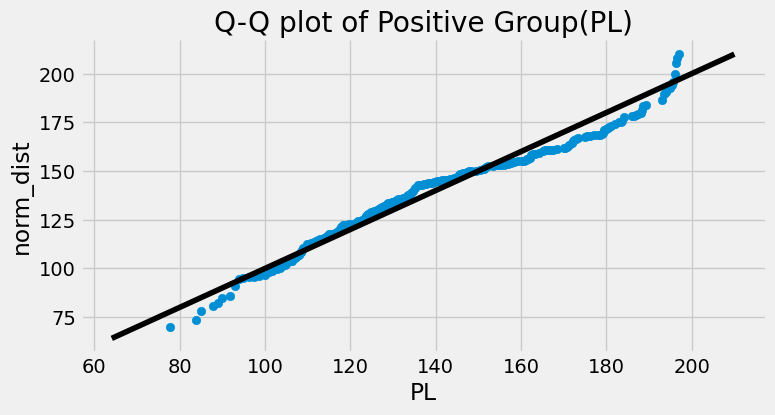

In [62]:
kde_qqplot(pos_group_PL, col=["PL"], group_name="Positive Group(PL)")

Doesn't look quite normal as there are observable deviations in both the kde and qq plot

- It's not quite clear from the visualizations whether the groups are normal. 
- For a conclusive inference, we conduct a normality test

In [63]:
## define noramlity test function

def normality_test(data, group_name, alpha=0.05):

    print("----" * 11 )
    print(f"Normality Test results for {group_name}")
    
    print("----" * 11)
    
    # Perform Shapiro-Wilk test
    statistic, p_value = shapiro(data)
    print(f"Shapiro-Wilk Test Statistic: {statistic:.3f}")
    print(f"P-value: {p_value:.3f}")

    # Interpret the results
    alpha = 0.05
    if p_value < alpha:
        print("Reject null hypothesis: Data is not normally distributed.")
    else:
        print("Fail to reject null hypothesis: Data is normally distributed.")

In [64]:
normality_test(pos_group_PL, "Positive Group(PL)")

--------------------------------------------
Normality Test results for Positive Group(PL)
--------------------------------------------
Shapiro-Wilk Test Statistic: 0.976
P-value: 0.001
Reject null hypothesis: Data is not normally distributed.


In [65]:
normality_test(neg_group_PL, "Negative Group(PL)")

--------------------------------------------
Normality Test results for Negative Group(PL)
--------------------------------------------
Shapiro-Wilk Test Statistic: 0.983
P-value: 0.000
Reject null hypothesis: Data is not normally distributed.


***Data Transformation***

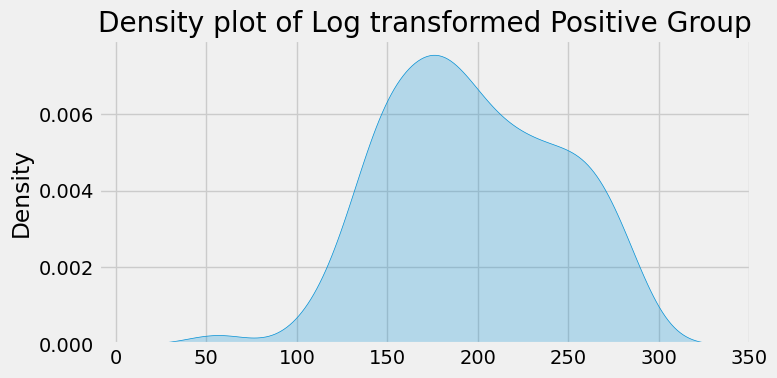

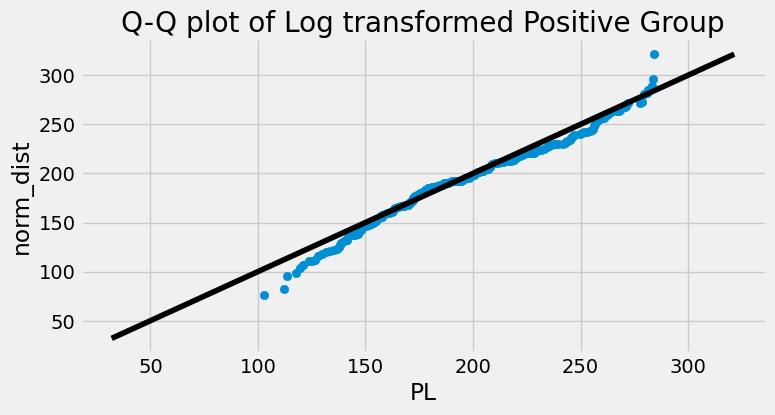

In [66]:
transformed_data, _ = boxcox(pos_group_PL)
kde_qqplot(data=transformed_data, col=["PL"], group_name="Log transformed Positive Group")

- non normality not resolved after transformation of `PL`
- We take a non parametric test approach 

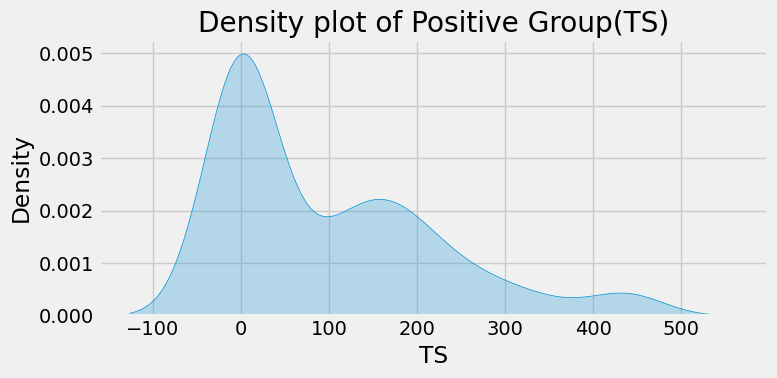

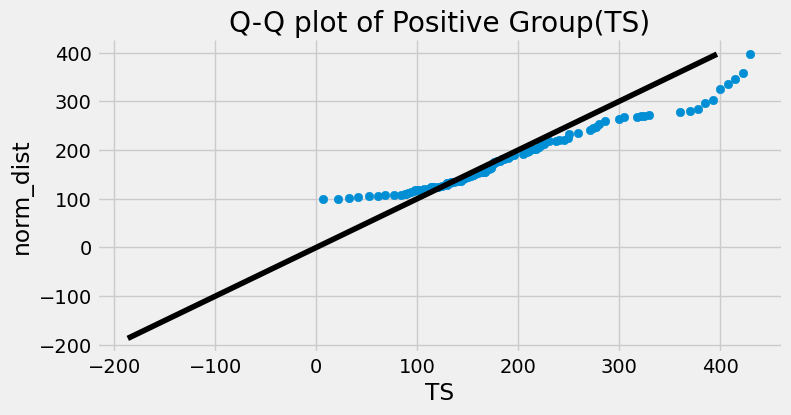

In [67]:
kde_qqplot(pos_group_TS, col=["TS"], group_name="Positive Group(TS)")

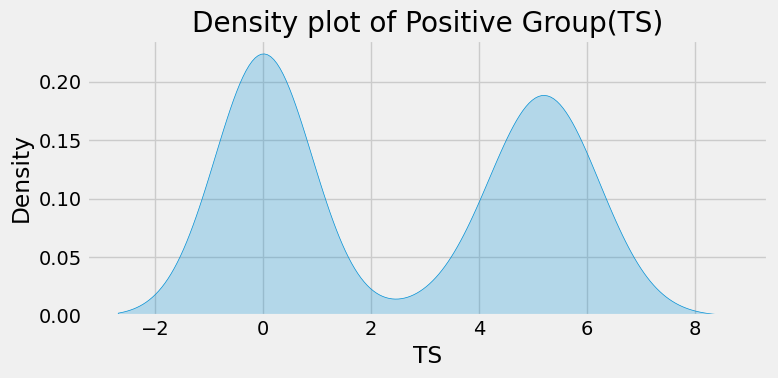

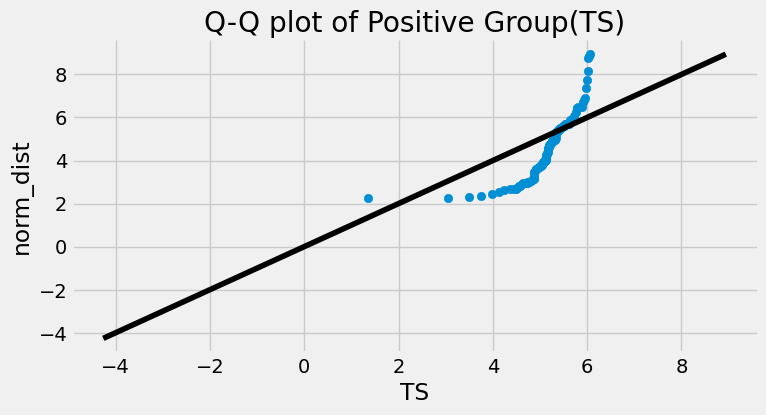

In [68]:
transformed_data = np.log1p(pos_group_TS)
kde_qqplot(transformed_data, col=["TS"], group_name="Positive Group(TS)")

- Due to the failed assumptions, we perform a non parameric test

### b. Perform the Test

In [70]:
def perform_test(group1, group2, var_name, alpha=0.05):
    
    print("------" * 10 )
    print(f"Mann-Whitney U Test results for {var_name}")
    
    print("------" * 10)
    
    # Perform Mann-Whitney U test
    u_stat, p_val = mannwhitneyu(group1, group2)
    print(f"U-statistic: {u_stat:.3f}")
    print(f"P-value: {p_val:.3f}")

    # Interpret results
    alpha = 0.05
    if p_val < alpha:
        print("Reject null hypothesis: There is a significant difference.")
    else:
        print("Fail to reject null hypothesis: No significant difference.")

In [71]:
## perform test for PL 

perform_test(group1=pos_group_PL, group2=neg_group_PL, var_name="PL(Blood Work Result-1)")

------------------------------------------------------------
Mann-Whitney U Test results for PL(Blood Work Result-1)
------------------------------------------------------------
U-statistic: 63670.000
P-value: 0.000
Reject null hypothesis: There is a significant difference.


In [72]:
## perform test for TS

perform_test(group1=pos_group_TS, group2=neg_group_TS, var_name="TS(Blood Work Result-3)")

------------------------------------------------------------
Mann-Whitney U Test results for TS(Blood Work Result-3)
------------------------------------------------------------
U-statistic: 44943.000
P-value: 0.024
Reject null hypothesis: There is a significant difference.


### c. Make a Decision

From the test performed, we **REJECT** the null hypothesis. This indicates that there is **SIGNIFICANT EVIDENCE** to support H1:

> ***Alternative Hypothesis (H1): There is A SIGNIFICANT DIFFERENCE in the means of PL(Blood Work Result-1) and TS(Blood Work Result-3) between patients with positive sepsis and patients with negative sepsis***


## 5 . Answering Analytical Questions 

***1. How many patients have valid insurance cards, and what percentage of patients does this represent?***

In [73]:
## number of patients with valid insurance
print(f"Patients with Valid Insurance: {data.Insurance.value_counts()[1]} ({data.Insurance.value_counts(normalize=True)[1]*100:.2f}%)")

## number of patients withoug valid insurance
print(f"Patients without Valid Insurance: {data.Insurance.value_counts()[0]} ({data.Insurance.value_counts(normalize=True)[0]*100:.2f}%)")


Patients with Valid Insurance: 411 (68.61%)
Patients without Valid Insurance: 188 (31.39%)


| Patients with Valid Insurance | Patients without Valid Insurance |
| ------------------------------- | -------------------------------- |
| 411 (68.61%)                   | 188 (31.39%)                     |


***2. What are the average plasma glucose (PRG) and blood pressure (PR) levels among patients?***


In [74]:
data.Insurance.value_counts().reset_index()

,Insurance,count
0,1,411
1,0,188


In [75]:
df_cluster = pd.read_pickle("../data/interim/df_cluster.pkl")
df_cluster

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis,pca_1,pca_2,pca_3,pca_4,pca_5,Cluster
0,0.352941,0.683544,0.500000,0.400000,0.000000,0.569760,0.406441,0.642659,0,Positive,0.386893,-0.101525,0.098509,-0.084066,0.016778,2
1,0.058824,0.284810,0.411765,0.331429,0.000000,0.397664,0.202110,0.221607,0,Negative,-0.270314,-0.104672,-0.027902,-0.069415,0.111628,0
2,0.470588,0.905063,0.382353,0.000000,0.000000,0.316533,0.439756,0.243767,1,Positive,0.124410,-0.196245,0.289869,0.155440,-0.306461,2
3,0.058824,0.310127,0.411765,0.262857,0.214857,0.434542,0.065889,0.000000,1,Negative,-0.386966,0.035793,-0.166647,0.093462,0.082263,0
4,0.000000,0.613924,0.058824,0.400000,0.384000,0.803319,1.000000,0.265928,1,Positive,0.026713,0.604190,0.612364,-0.124143,-0.009944,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,0.352941,0.525316,0.500000,0.514286,0.525714,0.569760,0.484916,0.288089,0,Negative,0.214150,0.383508,0.079020,0.059297,0.228420,2
595,0.000000,0.936709,0.647059,0.160000,0.422857,0.530424,0.447159,0.022161,1,Positive,0.030605,0.407243,0.001980,0.085342,-0.462084,3
596,0.000000,0.170886,0.558824,0.000000,0.000000,0.857406,0.085878,0.554017,1,Negative,-0.010589,-0.293146,-0.210836,-0.248313,0.036264,0
597,0.058824,0.310127,0.000000,0.217143,0.057143,0.427167,0.356098,0.000000,0,Negative,-0.521076,0.013073,0.265686,0.086784,0.098005,4


#


#  DATA PREPARATION

##  Feature Processing & Engineering

In [76]:
## Load data 

df_train = pd.read_csv("../data/raw/Paitients_Files_Train.csv").drop(["ID"], axis=1)
df_train.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,6,148,72,35,0,33.6,0.627,50,0,Positive
1,1,85,66,29,0,26.6,0.351,31,0,Negative
2,8,183,64,0,0,23.3,0.672,32,1,Positive
3,1,89,66,23,94,28.1,0.167,21,1,Negative
4,0,137,40,35,168,43.1,2.288,33,1,Positive


***Train Test Split***

In [77]:
## separate features from target

X = df_train.copy()
y = X.pop("Sepssis")

In [78]:
## split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=77)

Samples in train set: 479
Samples in test set: 120


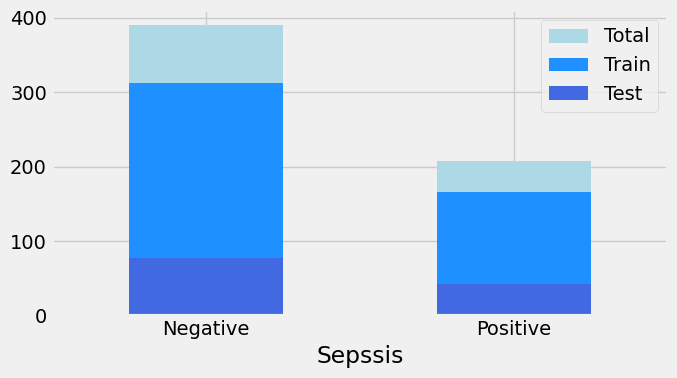

In [79]:
## check split

print(f"Samples in train set: {X_train.shape[0]}")
print(f"Samples in test set: {X_test.shape[0]}")

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(7, 4))

df_train["Sepssis"].value_counts().plot( kind="bar", ax=ax, color="lightblue", label="Total")
y_train.value_counts().plot(kind="bar", ax=ax, color="dodgerblue", label="Train")
y_test.value_counts().plot(kind="bar", ax=ax, color="royalblue", label="Test")
plt.xticks(rotation=0)
plt.legend();


In [80]:
# we will consider data imbalance if proportions above 70:30 

y_train.value_counts(normalize=True)

Sepssis
Negative    0.653445
Positive    0.346555
Name: proportion, dtype: float64

***Missing value imputation***

Although there are no missing values in the training data, we include an imputer in the pipeline. This allows for the possibility of predicting for patients who may be missing some information for some reason 

In [81]:
## extract numerical cols

num_cols = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']

In [82]:
## fit imputer

imputer = SimpleImputer(strategy="median")
X_train[num_cols] = imputer.fit_transform(X_train[num_cols])
X_train

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
406,4.0,115.0,72.0,0.0,0.0,28.9,0.376,46.0,1
565,2.0,95.0,54.0,14.0,88.0,26.1,0.748,22.0,1
190,3.0,111.0,62.0,0.0,0.0,22.6,0.142,21.0,1
343,5.0,122.0,86.0,0.0,0.0,34.7,0.290,33.0,0
171,6.0,134.0,70.0,23.0,130.0,35.4,0.542,29.0,1
...,...,...,...,...,...,...,...,...,...
515,3.0,163.0,70.0,18.0,105.0,31.6,0.268,28.0,0
550,1.0,116.0,70.0,28.0,0.0,27.4,0.204,21.0,0
192,7.0,159.0,66.0,0.0,0.0,30.4,0.383,36.0,1
92,7.0,81.0,78.0,40.0,48.0,46.7,0.261,42.0,1


In [83]:
## apply on test set
X_test[num_cols] = imputer.transform(X_test[num_cols])

***Engineering New Features***

In [84]:
## Define functions to categorize age and BMI

def categorize_age(age):
    if age <= 35:
        return 'Young Adult'
    elif age <= 60:
        return 'Middle-Aged Adult'
    else:
        return 'Elderly Adult'

def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal Weight'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'
    

In [85]:
X_train["BMICategory"] = X_train["M11"].apply(lambda x: categorize_bmi(x)) # create BMI categories
X_train["AgeCategory"] = X_train["Age"].apply(lambda x: categorize_age(x)) # create Age categories
X_train["GlucosePressureIndex"] = X_train["PRG"] / (X_train["PR"] + 0.1)  # Glucose - pressure index. add epsilon to avoid zero division
X_train["BloodWorkAverage"] = (X_train["PL"] + X_train["SK"] + X_train["TS"] + X_train["BD2"]) / 4 # blood work average
X_train["BMIPressureInteraction"] = X_train["M11"]*(X_train["PR"]+0.1) # bmi - blood  pressure  interaction
X_train.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,BMICategory,AgeCategory,GlucosePressureIndex,BloodWorkAverage,BMIPressureInteraction
406,4.0,115.0,72.0,0.0,0.0,28.9,0.376,46.0,1,Overweight,Middle-Aged Adult,0.055479,28.8440,2083.69
565,2.0,95.0,54.0,14.0,88.0,26.1,0.748,22.0,1,Overweight,Young Adult,0.036969,49.4370,1412.01
190,3.0,111.0,62.0,0.0,0.0,22.6,0.142,21.0,1,Normal Weight,Young Adult,0.048309,27.7855,1403.46
343,5.0,122.0,86.0,0.0,0.0,34.7,0.290,33.0,0,Obese,Young Adult,0.058072,30.5725,2987.67
171,6.0,134.0,70.0,23.0,130.0,35.4,0.542,29.0,1,Obese,Young Adult,0.085592,71.8855,2481.54


In [86]:
## apply on test set

X_test["BMICategory"] = X_test["M11"].apply(lambda x: categorize_bmi(x)) # create BMI categories
X_test["AgeCategory"] = X_test["Age"].apply(lambda x: categorize_age(x)) # create Age categories
X_test["GlucosePressureIndex"] = X_test["PRG"] / (X_test["PR"] + 0.1)  # Glucose - pressure index. add epsilon to avoid zero division
X_test["BloodWorkAverage"] = (X_test["PL"] + X_test["SK"] + X_test["TS"] + X_test["BD2"]) / 4 # blood work average
X_test["BMIPressureInteraction"] = X_test["M11"]*(X_test["PR"]+0.1) # bmi - blood  pressure  interaction
X_test.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,BMICategory,AgeCategory,GlucosePressureIndex,BloodWorkAverage,BMIPressureInteraction
201,1.0,138.0,82.0,0.0,0.0,40.1,0.236,28.0,1,Obese,Young Adult,0.012180,34.55900,3292.21
108,3.0,83.0,58.0,31.0,18.0,34.3,0.336,25.0,0,Obese,Young Adult,0.051635,33.08400,1992.83
466,0.0,74.0,52.0,10.0,36.0,27.8,0.269,22.0,0,Overweight,Young Adult,0.000000,30.06725,1448.38
433,2.0,139.0,75.0,0.0,0.0,25.6,0.167,29.0,0,Overweight,Young Adult,0.026631,34.79175,1922.56
271,2.0,108.0,62.0,32.0,56.0,25.2,0.128,21.0,1,Overweight,Young Adult,0.032206,49.03200,1564.92


In [87]:
augmented_num_cols = num_cols + ["GlucosePressureIndex", "BloodWorkAverage", "BMIPressureInteraction"]
X_train[augmented_num_cols]

,PRG,PL,PR,SK,TS,M11,BD2,Age,GlucosePressureIndex,BloodWorkAverage,BMIPressureInteraction
406,4.0,115.0,72.0,0.0,0.0,28.9,0.376,46.0,0.055479,28.84400,2083.69
565,2.0,95.0,54.0,14.0,88.0,26.1,0.748,22.0,0.036969,49.43700,1412.01
190,3.0,111.0,62.0,0.0,0.0,22.6,0.142,21.0,0.048309,27.78550,1403.46
343,5.0,122.0,86.0,0.0,0.0,34.7,0.290,33.0,0.058072,30.57250,2987.67
171,6.0,134.0,70.0,23.0,130.0,35.4,0.542,29.0,0.085592,71.88550,2481.54
...,...,...,...,...,...,...,...,...,...,...,...
515,3.0,163.0,70.0,18.0,105.0,31.6,0.268,28.0,0.042796,71.56700,2215.16
550,1.0,116.0,70.0,28.0,0.0,27.4,0.204,21.0,0.014265,36.05100,1920.74
192,7.0,159.0,66.0,0.0,0.0,30.4,0.383,36.0,0.105900,39.84575,2009.44
92,7.0,81.0,78.0,40.0,48.0,46.7,0.261,42.0,0.089629,42.31525,3647.27


In [88]:
X_train[["GlucosePressureIndex", "BloodWorkAverage", "BMIPressureInteraction"]].describe()

,GlucosePressureIndex,BloodWorkAverage,BMIPressureInteraction
count,479.000000,479.000000,479.000000
mean,1.596279,55.187502,2270.125449
std,10.347693,34.238828,888.379225
min,0.000000,5.035000,0.000000
25%,0.016103,32.253000,1765.740000
50%,0.044395,43.311000,2233.680000
75%,0.083240,71.583875,2734.485000
max,130.000000,245.582250,7387.710000


***Feature Scaling***

In [89]:
## fit scaler

scaler = MinMaxScaler()
X_train[augmented_num_cols] = scaler.fit_transform(X_train[augmented_num_cols] )
X_train

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,BMICategory,AgeCategory,GlucosePressureIndex,BloodWorkAverage,BMIPressureInteraction
406,0.235294,0.583756,0.590164,0.000000,0.000000,0.430700,0.127242,0.543478,1,Overweight,Middle-Aged Adult,0.000427,0.098978,0.282048
565,0.117647,0.482234,0.442623,0.141414,0.118280,0.388972,0.286080,0.021739,1,Overweight,Young Adult,0.000284,0.184587,0.191130
190,0.176471,0.563452,0.508197,0.000000,0.000000,0.336811,0.027327,0.000000,1,Normal Weight,Young Adult,0.000372,0.094578,0.189972
343,0.294118,0.619289,0.704918,0.000000,0.000000,0.517139,0.090521,0.260870,0,Obese,Young Adult,0.000447,0.106164,0.404411
171,0.352941,0.680203,0.573770,0.232323,0.174731,0.527571,0.198121,0.173913,1,Obese,Young Adult,0.000658,0.277910,0.335901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,0.176471,0.827411,0.573770,0.181818,0.141129,0.470939,0.081127,0.152174,0,Obese,Young Adult,0.000329,0.276586,0.299844
550,0.058824,0.588832,0.573770,0.282828,0.000000,0.408346,0.053800,0.000000,0,Overweight,Young Adult,0.000110,0.128939,0.259991
192,0.411765,0.807107,0.540984,0.000000,0.000000,0.453055,0.130231,0.326087,1,Obese,Middle-Aged Adult,0.000815,0.144715,0.271998
92,0.411765,0.411168,0.639344,0.404040,0.064516,0.695976,0.078138,0.456522,1,Obese,Middle-Aged Adult,0.000689,0.154981,0.493694


In [90]:
## apply scaler on test set
X_test[augmented_num_cols] = scaler.transform(X_test[augmented_num_cols])
X_test.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,BMICategory,AgeCategory,GlucosePressureIndex,BloodWorkAverage,BMIPressureInteraction
201,0.058824,0.700508,0.672131,0.000000,0.000000,0.597615,0.067464,0.152174,1,Obese,Young Adult,0.000094,0.122737,0.445633
108,0.176471,0.421320,0.475410,0.313131,0.024194,0.511177,0.110162,0.086957,0,Obese,Young Adult,0.000397,0.116605,0.269749
466,0.000000,0.375635,0.426230,0.101010,0.048387,0.414307,0.081554,0.021739,0,Overweight,Young Adult,0.000000,0.104064,0.196053
433,0.117647,0.705584,0.614754,0.000000,0.000000,0.381520,0.038002,0.173913,0,Overweight,Young Adult,0.000205,0.123704,0.260238
271,0.117647,0.548223,0.508197,0.323232,0.075269,0.375559,0.021349,0.000000,1,Overweight,Young Adult,0.000248,0.182904,0.211827


In [91]:
## create pca features

pca_instance = PCA(n_components=3)
pca_features = pd.DataFrame(
    pca_instance.fit_transform(X_train[num_cols]), 
    columns=[f"pca_{i}" for i in range(1, 4)],
    index = X_train.index
    )
pca_features 

,pca_1,pca_2,pca_3
406,0.237332,-0.218307,-0.073750
565,-0.299861,-0.077095,-0.058235
190,-0.255421,-0.267174,-0.081839
343,0.072342,-0.153297,-0.004328
171,0.007113,0.092989,-0.007951
...,...,...,...
515,-0.074326,0.077562,-0.151367
550,-0.315138,-0.043618,0.047574
192,0.192037,-0.140563,-0.192636
92,0.217209,0.024158,0.353566


In [92]:
#concatenate features
X_train =pd.concat([X_train, pca_features], axis=1)

In [93]:
# pca_features for test

pca_features = pd.DataFrame( pca_instance.transform(X_test[num_cols]),
             columns=[f"pca_{i}" for i in range(1, 4)],
             index = X_test.index)

X_test = pd.concat([X_test, pca_features], axis=1)
X_test

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,BMICategory,AgeCategory,GlucosePressureIndex,BloodWorkAverage,BMIPressureInteraction,pca_1,pca_2,pca_3
201,0.058824,0.700508,0.672131,0.000000,0.000000,0.597615,0.067464,0.152174,1,Obese,Young Adult,0.000094,0.122737,0.445633,-0.124554,-0.078936,-0.102602
108,0.176471,0.421320,0.475410,0.313131,0.024194,0.511177,0.110162,0.086957,0,Obese,Young Adult,0.000397,0.116605,0.269749,-0.231889,-0.078718,0.160733
466,0.000000,0.375635,0.426230,0.101010,0.048387,0.414307,0.081554,0.021739,0,Overweight,Young Adult,0.000000,0.104064,0.196053,-0.385655,-0.225043,0.016007
433,0.117647,0.705584,0.614754,0.000000,0.000000,0.381520,0.038002,0.173913,0,Overweight,Young Adult,0.000205,0.123704,0.260238,-0.096146,-0.169665,-0.147641
271,0.117647,0.548223,0.508197,0.323232,0.075269,0.375559,0.021349,0.000000,1,Overweight,Young Adult,0.000248,0.182904,0.211827,-0.310046,-0.040214,0.074485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,0.058824,0.649746,0.393443,0.454545,0.260753,0.603577,0.228437,0.065217,1,Obese,Young Adult,0.000160,0.361128,0.263688,-0.284803,0.274667,-0.016950
348,0.176471,0.502538,0.508197,0.191919,0.099462,0.324888,0.085824,0.108696,1,Normal Weight,Young Adult,0.000372,0.178904,0.183248,-0.193455,-0.125643,0.024421
255,0.058824,0.573604,0.524590,0.353535,0.000000,0.500745,0.198548,0.000000,0,Obese,Young Adult,0.000120,0.133449,0.291533,-0.324784,0.047065,0.057068
412,0.058824,0.725888,0.688525,0.232323,0.416667,0.631893,0.426132,0.021739,1,Obese,Young Adult,0.000091,0.474892,0.482672,-0.231401,0.410027,-0.109847


In [94]:
#cluster feature
kmeans_instance = KMeans(n_clusters=5, n_init=20, random_state=42)
X_train["Cluster"] = kmeans_instance.fit_predict(X_train[["PRG", "PR"]])
X_train

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,BMICategory,AgeCategory,GlucosePressureIndex,BloodWorkAverage,BMIPressureInteraction,pca_1,pca_2,pca_3,Cluster
406,0.235294,0.583756,0.590164,0.000000,0.000000,0.430700,0.127242,0.543478,1,Overweight,Middle-Aged Adult,0.000427,0.098978,0.282048,0.237332,-0.218307,-0.073750,2
565,0.117647,0.482234,0.442623,0.141414,0.118280,0.388972,0.286080,0.021739,1,Overweight,Young Adult,0.000284,0.184587,0.191130,-0.299861,-0.077095,-0.058235,3
190,0.176471,0.563452,0.508197,0.000000,0.000000,0.336811,0.027327,0.000000,1,Normal Weight,Young Adult,0.000372,0.094578,0.189972,-0.255421,-0.267174,-0.081839,3
343,0.294118,0.619289,0.704918,0.000000,0.000000,0.517139,0.090521,0.260870,0,Obese,Young Adult,0.000447,0.106164,0.404411,0.072342,-0.153297,-0.004328,2
171,0.352941,0.680203,0.573770,0.232323,0.174731,0.527571,0.198121,0.173913,1,Obese,Young Adult,0.000658,0.277910,0.335901,0.007113,0.092989,-0.007951,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,0.176471,0.827411,0.573770,0.181818,0.141129,0.470939,0.081127,0.152174,0,Obese,Young Adult,0.000329,0.276586,0.299844,-0.074326,0.077562,-0.151367,3
550,0.058824,0.588832,0.573770,0.282828,0.000000,0.408346,0.053800,0.000000,0,Overweight,Young Adult,0.000110,0.128939,0.259991,-0.315138,-0.043618,0.047574,3
192,0.411765,0.807107,0.540984,0.000000,0.000000,0.453055,0.130231,0.326087,1,Obese,Middle-Aged Adult,0.000815,0.144715,0.271998,0.192037,-0.140563,-0.192636,2
92,0.411765,0.411168,0.639344,0.404040,0.064516,0.695976,0.078138,0.456522,1,Obese,Middle-Aged Adult,0.000689,0.154981,0.493694,0.217209,0.024158,0.353566,2


In [95]:
## apply on test set 
X_test["Cluster"] = kmeans_instance.predict(X_test[["PRG", "PR"]])

***Feature Encoding***

In [96]:
## extract categorical cols and instantiate encoders

cat_cols = ['BMICategory', 'AgeCategory']
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
le = LabelEncoder()

In [97]:
y_train_encoded = le.fit_transform(y_train)
encoded_features = pd.DataFrame(ohe.fit_transform(X_train[cat_cols]), index=X_train.index, columns=ohe.get_feature_names_out())
encoded_features

,BMICategory_Normal Weight,BMICategory_Obese,BMICategory_Overweight,BMICategory_Underweight,AgeCategory_Elderly Adult,AgeCategory_Middle-Aged Adult,AgeCategory_Young Adult
406,0.0,0.0,1.0,0.0,0.0,1.0,0.0
565,0.0,0.0,1.0,0.0,0.0,0.0,1.0
190,1.0,0.0,0.0,0.0,0.0,0.0,1.0
343,0.0,1.0,0.0,0.0,0.0,0.0,1.0
171,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
515,0.0,1.0,0.0,0.0,0.0,0.0,1.0
550,0.0,0.0,1.0,0.0,0.0,0.0,1.0
192,0.0,1.0,0.0,0.0,0.0,1.0,0.0
92,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [98]:
X_train = pd.concat([X_train,  encoded_features], axis=1)
X_train = X_train.drop(cat_cols, axis=1)
X_train

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,GlucosePressureIndex,...,pca_2,pca_3,Cluster,BMICategory_Normal Weight,BMICategory_Obese,BMICategory_Overweight,BMICategory_Underweight,AgeCategory_Elderly Adult,AgeCategory_Middle-Aged Adult,AgeCategory_Young Adult
406,0.235294,0.583756,0.590164,0.000000,0.000000,0.430700,0.127242,0.543478,1,0.000427,...,-0.218307,-0.073750,2,0.0,0.0,1.0,0.0,0.0,1.0,0.0
565,0.117647,0.482234,0.442623,0.141414,0.118280,0.388972,0.286080,0.021739,1,0.000284,...,-0.077095,-0.058235,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0
190,0.176471,0.563452,0.508197,0.000000,0.000000,0.336811,0.027327,0.000000,1,0.000372,...,-0.267174,-0.081839,3,1.0,0.0,0.0,0.0,0.0,0.0,1.0
343,0.294118,0.619289,0.704918,0.000000,0.000000,0.517139,0.090521,0.260870,0,0.000447,...,-0.153297,-0.004328,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0
171,0.352941,0.680203,0.573770,0.232323,0.174731,0.527571,0.198121,0.173913,1,0.000658,...,0.092989,-0.007951,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,0.176471,0.827411,0.573770,0.181818,0.141129,0.470939,0.081127,0.152174,0,0.000329,...,0.077562,-0.151367,3,0.0,1.0,0.0,0.0,0.0,0.0,1.0
550,0.058824,0.588832,0.573770,0.282828,0.000000,0.408346,0.053800,0.000000,0,0.000110,...,-0.043618,0.047574,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0
192,0.411765,0.807107,0.540984,0.000000,0.000000,0.453055,0.130231,0.326087,1,0.000815,...,-0.140563,-0.192636,2,0.0,1.0,0.0,0.0,0.0,1.0,0.0
92,0.411765,0.411168,0.639344,0.404040,0.064516,0.695976,0.078138,0.456522,1,0.000689,...,0.024158,0.353566,2,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [99]:
# apply encoder to test set

encoded_features = pd.DataFrame(ohe.transform(X_test[cat_cols]), index=X_test.index, columns=ohe.get_feature_names_out())
X_test = pd.concat([X_test,  encoded_features], axis=1)
X_test = X_test.drop(cat_cols, axis=1)
X_test

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,GlucosePressureIndex,...,pca_2,pca_3,Cluster,BMICategory_Normal Weight,BMICategory_Obese,BMICategory_Overweight,BMICategory_Underweight,AgeCategory_Elderly Adult,AgeCategory_Middle-Aged Adult,AgeCategory_Young Adult
201,0.058824,0.700508,0.672131,0.000000,0.000000,0.597615,0.067464,0.152174,1,0.000094,...,-0.078936,-0.102602,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
108,0.176471,0.421320,0.475410,0.313131,0.024194,0.511177,0.110162,0.086957,0,0.000397,...,-0.078718,0.160733,3,0.0,1.0,0.0,0.0,0.0,0.0,1.0
466,0.000000,0.375635,0.426230,0.101010,0.048387,0.414307,0.081554,0.021739,0,0.000000,...,-0.225043,0.016007,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0
433,0.117647,0.705584,0.614754,0.000000,0.000000,0.381520,0.038002,0.173913,0,0.000205,...,-0.169665,-0.147641,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0
271,0.117647,0.548223,0.508197,0.323232,0.075269,0.375559,0.021349,0.000000,1,0.000248,...,-0.040214,0.074485,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,0.058824,0.649746,0.393443,0.454545,0.260753,0.603577,0.228437,0.065217,1,0.000160,...,0.274667,-0.016950,3,0.0,1.0,0.0,0.0,0.0,0.0,1.0
348,0.176471,0.502538,0.508197,0.191919,0.099462,0.324888,0.085824,0.108696,1,0.000372,...,-0.125643,0.024421,3,1.0,0.0,0.0,0.0,0.0,0.0,1.0
255,0.058824,0.573604,0.524590,0.353535,0.000000,0.500745,0.198548,0.000000,0,0.000120,...,0.047065,0.057068,3,0.0,1.0,0.0,0.0,0.0,0.0,1.0
412,0.058824,0.725888,0.688525,0.232323,0.416667,0.631893,0.426132,0.021739,1,0.000091,...,0.410027,-0.109847,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [100]:
y_test_encoded = le.transform(y_test)

***Feature Transformation***

Different transfromations investigated didn't significantly affect distribution shape. We skip it. Training data is prepared for predictive modelling

#


#  PREDICTIVE MODELLING

***split features into subsets***


In [101]:
basic_features = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance']
interaction_features = ['GlucosePressureIndex', 'BloodWorkAverage', 'BMIPressureInteraction']
pca_features = ['pca_1', 'pca_2', 'pca_3']
cat_features = ['BMICategory_Normal Weight', 'BMICategory_Obese',
       'BMICategory_Overweight', 'BMICategory_Underweight',
       'AgeCategory_Elderly Adult', 'AgeCategory_Middle-Aged Adult',
       'AgeCategory_Young Adult']
cluster_feature =["Cluster"]

feature_set_0 = basic_features
feature_set_1 = list(set(basic_features + interaction_features))
feature_set_2 = list(set(feature_set_1 + pca_features))
feature_set_3 = list(set(feature_set_2 + cat_features + cluster_feature)) # contains all features


In [103]:


from LearningAlgorithms import ClassificationAlgorithms

***forward feature selection***

- we use forward selection to determine the top 10 best features using decision tree and f1-score. 
- Although this is done on the training set, the results can still be useful in giving us an idea of features likely to perform well on the test set. 
- the algo works by looping through all the columns and training a decision tree on each feature at a time then comparing scores to select the best features.
- The best feature is saved and the process is repeated to find the next best feature. 

In [104]:
learner = ClassificationAlgorithms()

max_features = 10

selected_features, ordered_features, ordered_scores = learner.forward_selection(max_features, X_train, y_train)

0


1
2
3
4
5
6
7
8
9


In [105]:
selected_features

['TS',
 'BMIPressureInteraction',
 'BloodWorkAverage',
 'Age',
 'GlucosePressureIndex',
 'PRG',
 'BMICategory_Normal Weight',
 'AgeCategory_Middle-Aged Adult',
 'BMICategory_Underweight',
 'AgeCategory_Young Adult']

In [106]:
ordered_scores

[0.7578288100208769,
 0.9018789144050104,
 0.9394572025052192,
 0.9519832985386222,
 0.9624217118997912,
 0.9519832985386222,
 0.9707724425887265,
 0.9749478079331941,
 0.9707724425887265,
 0.9707724425887265]

In [107]:
## save selected features to avoid rerun algo
selected_features = ['TS',
 'BMIPressureInteraction',
 'BloodWorkAverage',
 'Age',
 'PRG',
 'BMICategory_Overweight',
 'AgeCategory_Young Adult',
 'GlucosePressureIndex',
 'BMICategory_Underweight',
 'Insurance']

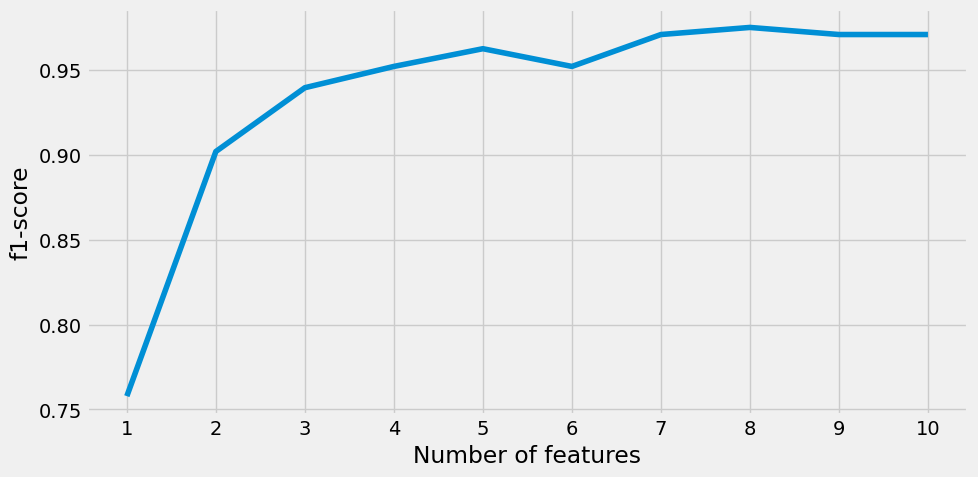

In [108]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, max_features + 1), ordered_scores)
plt.xlabel("Number of features")
plt.ylabel("f1-score")
plt.xticks(np.arange(1, max_features + 1));

- first 3 most important features achieve about 94% f1-score. 
- we use f1-score metric since both false negative and false positive have grievious consequencies and hence must be minimized. 
- also since both classes do not have nearly about the same number of samples. 


In [109]:

iterations = 1
score_df = pd.DataFrame()

possible_feature_sets = [feature_set_0, feature_set_1, feature_set_2, feature_set_3, selected_features]
feature_names = ["feature set 0", "feature set 1", "feature set 2", "feature set 3", "selected features"]

- neural netwrok and random forest are stochastic, so we train them a number of times(`iterations`) and average the f1-scores
- here, we're training 5 models while performing gridsearch. This is done for each feature set created 


In [110]:

for i, f in zip(range(len(possible_feature_sets)), feature_names):
    print("Feature set:", i)
    selected_train_X = X_train[possible_feature_sets[i]]
    selected_test_X = X_test[possible_feature_sets[i]]

    # First run non deterministic classifiers to average their score.
    performance_test_nn = 0
    performance_test_rf = 0

    for it in range(0, iterations):
        print("\tTraining neural network,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.feedforward_neural_network(
            selected_train_X,
            y_train,
            selected_test_X,
            gridsearch=False,
        )
        performance_test_nn += accuracy_score(y_test, class_test_y)

        print("\tTraining random forest,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.random_forest(
            selected_train_X, y_train, selected_test_X, gridsearch=True
        )
        performance_test_rf += accuracy_score(y_test, class_test_y)

    performance_test_nn = performance_test_nn / iterations
    performance_test_rf = performance_test_rf / iterations

    # And we run our deterministic classifiers:
    print("\tTraining KNN")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.k_nearest_neighbor(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_knn = accuracy_score(y_test, class_test_y)

    print("\tTraining decision tree")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.decision_tree(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_dt = accuracy_score(y_test, class_test_y)

    print("\tTraining naive bayes")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.naive_bayes(selected_train_X, y_train, selected_test_X)

    performance_test_nb = accuracy_score(y_test, class_test_y)

    # Save results to dataframe
    models = ["NN", "RF", "KNN", "DT", "NB"]
    new_scores = pd.DataFrame(
        {
            "model": models,
            "feature_set": f,
            "accuracy": [
                performance_test_nn,
                performance_test_rf,
                performance_test_knn,
                performance_test_dt,
                performance_test_nb,
            ],
        }
    ) 
    score_df = pd.concat([score_df, new_scores])

Feature set: 0
	Training neural network, 0


	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 1
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 2
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 3
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 4
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes


In [111]:
score_df_sorted = score_df.sort_values(by="accuracy", ascending=False)
score_df_sorted

,model,feature_set,accuracy
0,NN,feature set 1,0.783333
0,NN,feature set 2,0.775000
4,NB,feature set 0,0.775000
1,RF,selected features,0.766667
0,NN,feature set 3,0.766667
1,RF,feature set 0,0.766667
4,NB,feature set 3,0.766667
4,NB,feature set 1,0.758333
3,DT,feature set 2,0.758333
3,DT,feature set 3,0.758333


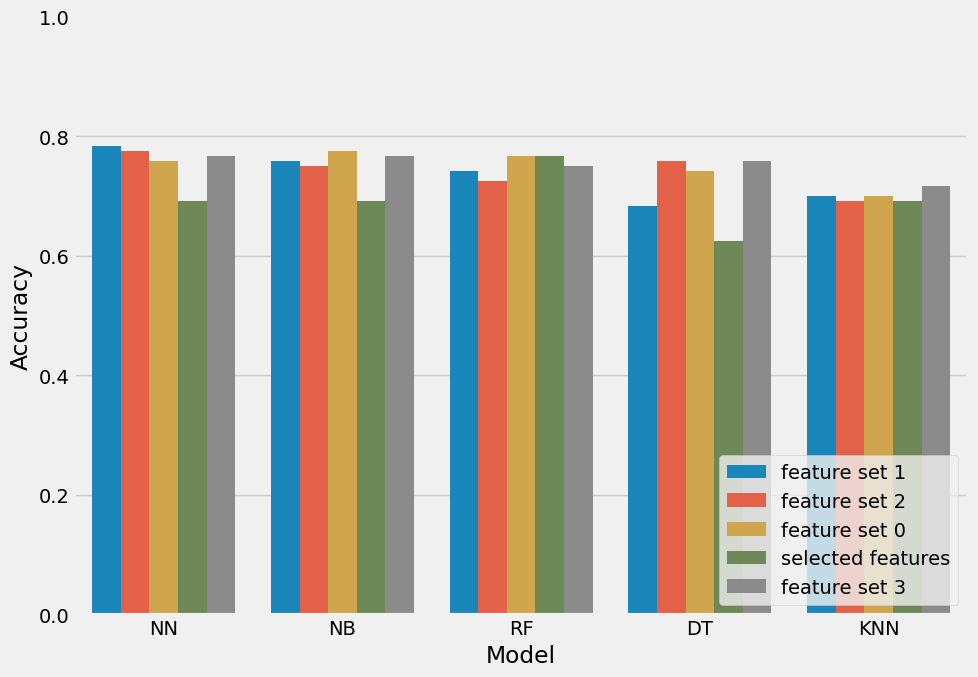

In [112]:
plt.figure(figsize=(10, 7))
sns.barplot(x="model", y="accuracy", hue="feature_set", data=score_df_sorted)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend(loc="lower right") 

- The engineered features doesn't seem to have significant impact on the accuracy of the models. 
- 

In [113]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import pickle

In [114]:
# Create the model
nb = GaussianNB()

# Fit the model
nb.fit(X_train[feature_set_0], y_train_encoded)

GaussianNB()

In [115]:
accuracy_score(nb.predict(X_test[feature_set_0]), y_test_encoded)

0.775

In [116]:
with open("../models/nb_model.pkl", "wb") as f:
    pickle.dump(nb, f)

In [117]:
param_grid = [
                {
                    "min_samples_leaf": [2, 10, 50, 100, 200],
                    "n_estimators": [10, 50, 100],
                    "criterion": ["gini", "entropy"],
                }
            ]
rf = GridSearchCV(
    RandomForestClassifier(), param_grid, cv=5, scoring="accuracy"
)

# Fit the grid search to the data
rf.fit(X_train[feature_set_0], y_train_encoded)

# Print the best parameters found
print("Best parameters: {}".format(rf.best_params_))

# Evaluate the model with best parameters on the test set
rf_model = rf.best_estimator_
test_score = rf_model.score(X_test[feature_set_0], y_test_encoded)
print("Test set accuracy with best model: {:.2f}".format(test_score))

Best parameters: {'criterion': 'entropy', 'min_samples_leaf': 2, 'n_estimators': 100}
Test set accuracy with best model: 0.75


In [118]:
rf_model

RandomForestClassifier(criterion='entropy', min_samples_leaf=2)

In [119]:
with open("../models/rf_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

In [120]:
param_grid = {
    'C': [0.01, 0.1, 1, 10,],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
}

# Set up the grid search
lr = GridSearchCV(LogisticRegression(), param_grid, cv=3)

# Fit the grid search to the data
lr.fit(X_train[feature_set_0], y_train_encoded)

# Print the best parameters found
print("Best parameters: {}".format(lr.best_params_))

# Evaluate the model with best parameters on the test set
lr_model = lr.best_estimator_
test_score = lr_model.score(X_test[feature_set_0], y_test_encoded)
print("Test set accuracy with best model: {:.2f}".format(test_score))

Best parameters: {'C': 10, 'class_weight': None}
Test set accuracy with best model: 0.77


In [121]:
lr_model

LogisticRegression(C=10)

In [122]:
with open("../models/lr_model.pkl", "wb") as f:
    pickle.dump(lr_model, f)

#

#


# VI. MODEL PERSISTENCE & USAGE DEMONSTRATION

In [123]:
## Load data 
df_train = pd.read_csv("../data/raw/Paitients_Files_Train.csv").drop(["ID"], axis=1)

## separate features from target
X = df_train.copy()
y = X.pop("Sepssis")

## split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=77)

## extract numerical cols
num_cols = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']

***Build pipeline***

In [124]:
# Create the pipeline for numerical columns
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Imputation of missing values using the median
    ('scaler', MinMaxScaler())  # Scaling numerical columns using MinMaxScaler
])

# Create the column transformer to handle both numerical and categorical columns
preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_cols)  # Apply the numeric_pipeline to numerical features
], remainder='passthrough')  

In [125]:
nb_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Include the preprocessor in the pipeline
    ('classifier', GaussianNB())  # Include a classifier,
])


In [126]:
nb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['PRG', 'PL', 'PR', 'SK',
                                                   'TS', 'M11', 'BD2',
                                                   'Age'])])),
                ('classifier', GaussianNB())])

In [127]:
accuracy_score(y_test, nb_pipeline.predict(X_test))

0.775

In [128]:
with open("../models/nb_pipeline.pkl", "wb") as f:
    pickle.dump(nb_pipeline, f)

In [129]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Include the preprocessor in the pipeline
    ('classifier', RandomForestClassifier(criterion="entropy", min_samples_leaf=2, n_estimators=100))  # Include a classifier,
])


In [130]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['PRG', 'PL', 'PR', 'SK',
                                                   'TS', 'M11', 'BD2',
                                                   'Age'])])),
                ('classifier',
                 RandomForestClassifier(criterion='entropy',
                                        min_samples_leaf=2))])

In [131]:
accuracy_score(y_test, rf_pipeline.predict(X_test))

0.7666666666666667

In [132]:
with open("../models/rf_pipeline.pkl", "wb") as f:
    pickle.dump(rf_pipeline, f)

In [133]:
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Include the preprocessor in the pipeline
    ('classifier', LogisticRegression(C=10))  # Include a classifier,
])

In [134]:
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['PRG', 'PL', 'PR', 'SK',
                                                   'TS', 'M11', 'BD2',
                                                   'Age'])])),
                ('classifier', LogisticRegression(C=10))])

In [135]:
accuracy_score(y_test, lr_pipeline.predict(X_test))

0.7666666666666667

In [136]:
with open("../models/lr_pipeline.pkl", "wb") as f:
    pickle.dump(lr_pipeline, f)